## esegui all'inizio

In [ ]:
import h5py
import os
import numpy as np
import numpy as np
from tensorflow.keras.models import load_model

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import Lasso
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
#import pymrmr
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc




# Percorso del file HDF5 da cui caricare i dati
load_path = "/Users/alessiamenozzi/Desktop/ThesisPlaques/classificator_data.h5"
#load_path = "C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\classificator_data.h5"

# Inizializza le liste per contenere i dati
loaded_class_images = []
loaded_class_labels = None
loaded_patients = None

# Apre il file HDF5 in modalità lettura
with h5py.File(load_path, 'r') as hf:
    # Itera su tutti i gruppi nel file HDF5
    for group_name in hf.keys():
        # Controlla se il nome del gruppo inizia con "patient_"
        if group_name.startswith("patient_"):
            group = hf[group_name]
            # Carica le immagini dal dataset 'images' all'interno del gruppo
            loaded_class_images.append(np.array(group['images']))
        elif group_name == "labels":
            # Carica le etichette dal dataset 'labels'
            loaded_class_labels = hf['labels'][:]
        elif group_name == "patients":
            # Carica i numeri dei pazienti dal dataset 'patients'
            loaded_patients = hf['patients'][:]

print(f"Dati caricati da {load_path}")
print(f"Numero di pazienti: {len(loaded_class_images)}")
print(f"Esempio di immagini per paziente: {loaded_class_images[0].shape}")


# Carica il file CSV
file_path = "/Users/alessiamenozzi/Desktop/ThesisPlaques/data_rad_clin_DEF.csv"
#file_path = "C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\data_rad_clin_DEF.csv"
data = pd.read_csv(file_path)

# Lista degli ID da escludere
ids_to_exclude = ["patient_TC_19", "patient_TC_40", "patient_TC_88", "patient_TC_150", "patient_TC_193"]

# Filtra il DataFrame per escludere le righe con gli ID specificati
filtered_data = data[~data['IDs_new'].isin(ids_to_exclude)]

# Estrae i valori dalla colonna 'label' del DataFrame filtrato
labels_column = filtered_data['label']

# Converte i valori della colonna 'label' in numeri interi
labels = labels_column.astype(int).tolist()

labels=np.array(labels)
print("Labels:", labels)
print("Number of labels:", len(labels))


# Carica il modello encoder
encoder = load_model("/Users/alessiamenozzi/Desktop/ThesisPlaques/encoder_models/encoder_model32.h5", compile=False)
#encoder = load_model("C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\encoder_models\\encoder_model64.h5", compile=False)

# Funzione per ottenere le feature da una singola immagine
def get_features_from_image(image):
    image = image.astype('float32')
    image = image / 255.0
    # Ottieni le feature dall'encoder
    if len(image.shape) == 2:  # Se l'immagine è 64x64
        image = np.expand_dims(image, axis=-1)  # Aggiungi canale se necessario (per immagini in bianco e nero)
    image = np.expand_dims(image, axis=0)  # Aggiungi dimensione batch
    features = encoder.predict(image, verbose=False)
    features = np.squeeze(features)
    #print(features.shape)
    return np.array(features)

# Lista per salvare le feature delle immagini
patients = []

# Ottieni le feature per ogni immagine nella lista
for i in range(len(loaded_class_images)):
    features_list = []
    for img in loaded_class_images[i]:
        features = get_features_from_image(img)
        features_list.append(features)
    fetures_list = np.array(features_list)
    patients.append(features_list)

Dati caricati da /Users/alessiamenozzi/Desktop/ThesisPlaques/classificator_data.h5
Numero di pazienti: 124
Esempio di immagini per paziente: (28, 64, 64)
Labels: [0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0
 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0
 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 1 1 0 1 0 1]
Number of labels: 124


## funzioni 1

In [ ]:
## FILE DI FUNZIONI
import h5py
import os
import numpy as np
import numpy as np
from tensorflow.keras.models import load_model

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import Lasso
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
#import pymrmr


from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc


def continue_array(filtered_patients, labels):
    all_features = []
    for patient in filtered_patients:
        for image_features in patient:
            all_features.append(image_features)

    all_features_array = np.array(all_features)

    # Print the shape of the combined features array
    #print(f"Shape of combined features array: {all_features_array.shape}")

    # Initialize the new expanded labels and patient IDs vectors
    expanded_labels = []
    expanded_patient_ids = []

    # Assuming labels and loaded_patients are already defined
    # labels: A list of length 124 with labels for each patient
    # loaded_patients: A list of length 124 with IDs for each patient

    # Iterate over the filtered patients and expand the labels and patient IDs
    for i in range(len(filtered_patients)):
        num_images = len(filtered_patients[i])  # Number of images for the current patient
        expanded_labels.extend([labels[i]] * num_images)  # Assign the same label to all images of the patient
        expanded_patient_ids.extend([loaded_patients[i]] * num_images)  # Assign the same patient ID to all images of the patient

    # Convert the lists to NumPy arrays
    expanded_labels_array = np.array(expanded_labels)
    expanded_patient_ids_array = np.array(expanded_patient_ids)

    # Print the shapes of the new arrays to verify
    #print(f"Shape of expanded labels array: {expanded_labels_array.shape}")
    #print(f"Shape of expanded patient IDs array: {expanded_patient_ids_array.shape}")
    return all_features_array, expanded_labels_array, expanded_patient_ids_array


def filter_highly_correlated_features(df, corr, threshold=0.85):
    columns = np.full((corr.shape[0],), True, dtype=bool)
    removed_features = []

    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= threshold:
                if columns[j]:
                    columns[j] = False
                    removed_features.append(df.columns[j])

    #selected_columns = df.columns[columns]
    print(f"Removed features: {removed_features}")
    return removed_features



def remove_features_from_patients(patients, features_to_remove):
    # Estrai gli indici delle caratteristiche da rimuovere
    feature_indices_to_remove = [int(feature.split('_')[1]) for feature in features_to_remove]
    
    # Rimuovi le caratteristiche corrispondenti dagli array dei pazienti
    final_patients = []
    for patient in patients:
        new_patients = []
        for image_features in patient:
            new_patient = np.delete(image_features, feature_indices_to_remove, axis=0)
            new_patients.append(new_patient)
        final_patients.append(np.array(new_patients))    

    return final_patients


def perform_correlation(z_train, y_train, numero = 32, threshold = 0.85):
    # Supponiamo che loaded_patients contenga le etichette dei pazienti

    all_images, _, _= continue_array(z_train, y_train)

    # Creazione del DataFrame con le immagini come righe e le features come colonne
    df = pd.DataFrame(all_images, columns=[f'feature_{i}' for i in range(numero)])

    # Visualizzazione del DataFrame
    print(df.shape)
    corr_matrix = df.corr()

    # Se vuoi anche visualizzare la matrice di correlazione con Seaborn
    #plt.figure(figsize=(12, 10))
    #sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    #plt.title("Feature Correlation Matrix")
    #plt.show()  
    
    features_selected = filter_highly_correlated_features(df, corr_matrix, threshold)
    
    return features_selected



## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    # Fit Lasso regression model
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)

    # Get coefficients
    coefficients = lasso.coef_

    # Select features with non-zero coefficients
    selected_features = np.where(coefficients != 0)[0]

    # Create new feature matrix with only selected features
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    # Create new feature matrix with only selected features
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FEATURE SELECTION MRMR
def mrmr_feature_selection(X, y, num_features):
    feature_names = [f'feature_{i}' for i in range(X.shape[1])]
    data = pd.DataFrame(X, columns=feature_names)
    data['target'] = y
    data.columns = data.columns.astype(str)
    selected_features = pymrmr.mRMR(data, 'MIQ', num_features)
    selected_indices = [data.columns.get_loc(feature) for feature in selected_features]
    # Crea una nuova matrice delle caratteristiche con solo le caratteristiche selezionate
    X_selected = X[:, selected_indices]

    return X_selected, selected_indices

## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    # Inizializza il classificatore Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    # Addestra il modello
    rf.fit(X, y)
    # Ottieni l'importanza delle caratteristiche
    feature_importances = rf.feature_importances_
    # Seleziona gli indici delle caratteristiche più importanti
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    # Crea una nuova matrice di caratteristiche con solo le caratteristiche selezionate
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FUNZIONE PER RIMUOVERE FEATURES SELEZIONATE
def filter_patients_features(filtered_patients, selected_features):
    """
    Removes the non-selected features from the filtered_patients array.

    Parameters:
    filtered_patients (list of numpy.ndarray): The list containing patients' images' features.
    selected_features (numpy.ndarray): The indices of the selected features.

    Returns:
    list of numpy.ndarray: The new filtered_patients array with only the selected features.
    """
    filtered_patients_selected = []

    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected




## funzioni 2 per la classificazione

### classificazione

In [ ]:
def prob_to_binary(predictions_proba, threshold):
        final_predictionarray=[]          
        ## majority voting
        for p in predictions_proba:
            test_patient_predictions=[]
            for proba in p:               
                predictions_binary = 1 if proba[0][1] > threshold else 0
                test_patient_predictions.append(predictions_binary)
            count_0 = np.sum(np.array(test_patient_predictions)==0) 
            count_1 = np.sum(np.array(test_patient_predictions)==1)                                   
            final_prediction = 0 if count_0 > count_1 else 1
            final_predictionarray.append(final_prediction)
         
    
        return final_predictionarray


def classification_method1(selector, alpha, classifier, x_train_expanded, y_train_expanded, patients_test, y_test, features_test, num_features, thresholds=np.arange(0.001, 0.501, 0.001)):

    if num_features != len(x_train_expanded[0]) or alpha != 0:
        if selector == "lasso":
            X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
        elif selector == "logistic": 
            X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
        elif selector == "mrmr":
            X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
        elif selector == "rf":
            X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
        else:
            print("Wrong selector. Choose between: mrmr, rf, logistic, lasso")
            return
        
        features_test = filter_patients_features(features_test, selected_features)

    else:
        X_selected = x_train_expanded

    #print("X_selected[0] ", X_selected[0])
    #print("X_selected[1] ", X_selected[1])
    
    smote = SMOTE(random_state=42)

    # Applicare SMOTE al set di dati di addestramento espanso
    X_resampled, y_resampled = smote.fit_resample(X_selected, y_train_expanded)
    #print(X_selected, " vs Resampled ", X_resampled)
    #print(y_test, "vs resempled " , y_resampled)
    #classifier.fit(X_selected, y_train_expanded)
    classifier.fit(X_resampled, y_resampled)

   
    ### questo trova le probabilità e fa la media
    temp_array = []
    patient_scores = []

    for x in range(len(patients_test)):
        patient_predictions = []
        patient_predictions1 = []
        for i in range(len(features_test[x])):
            dato = features_test[x][i].reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            prediction1 = classifier.predict_proba(dato)[:,1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean=np.mean(patient_predictions1)

        patient_scores.append(mean) ## contiene la media delle probabilità
        temp_array.append(patient_predictions) ## contiene tutte le probabilità
    


    best_f1_score = 0
    best_threshold = None
    best_precision=0
    best_recall=0
    best_prediction=[]
    

    # Valuta le performance utilizzando diverse threshold
    #thresholds = np.arange(0.001, 0.501, 0.001)
    #thresholds=[0.5]
    if isinstance(thresholds, (int, float, complex)):
        thresholds=[thresholds]

    ## se non viene specificato usi il parametro di default 
    if(len(thresholds)!=1):
        for threshold in thresholds:
            binary_predictions = prob_to_binary(temp_array, threshold)
            f1 = f1_score(y_test, binary_predictions)
            if f1 > best_f1_score:
                best_f1_score = f1
                best_threshold = threshold
                best_precision = precision_score(y_test, binary_predictions)
                best_recall = recall_score(y_test, binary_predictions)
                best_prediction=binary_predictions

    else: ## qui vuol dire che è il set di test che usa la threshold migliore
        best_threshold = thresholds
        best_prediction=prob_to_binary(temp_array, best_threshold)
        best_f1_score = f1_score(y_test, best_prediction)
        best_precision = precision_score(y_test, best_prediction)
        best_recall = recall_score(y_test, best_prediction)

    #print(f"La migliore threshold è {best_threshold} con f1score di {best_f1_score} e precision {best_precision} e recall {best_recall}.")

    y_test= np.array(y_test)
    best_prediction=np.array(best_prediction)
    test_accuracy = accuracy_score(y_test, best_prediction)


    #test_precision = precision_score(y_test, best_prediction)
    #test_recall = recall_score(y_test, best_prediction)
    
    precision, recall, _ = precision_recall_curve(y_test, patient_scores)
    pr_auc = average_precision_score(y_test, patient_scores)

    #fpr, tpr, _ = roc_curve(y_test, best_prediction)
    roc_auc= roc_auc_score(y_test, patient_scores)


    conf= confusion_matrix(y_test, best_prediction)

    return best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, best_threshold



### best threshold

In [ ]:
def find_best_threshold_features(results_rf, selector):
    best_thresholds = []
    best_num_features=[]
    best_alpha=[]

    for i in range(len(results_rf)):
        fold_results = results_rf[i][selector]
        
        # Inizialmente, tutti gli indici con il massimo F1 score
        best_f1_indices = np.where(fold_results['f1'] == np.max(fold_results['f1']))[0]
        print("best_f1_indices prima volta ", best_f1_indices)
        
        if len(best_f1_indices) > 1:
            print("sto tagliando")
            # In caso di parità di F1, considera il pr_auc
            max_pr_auc = max(fold_results['pr_auc'][j] for j in best_f1_indices)
            best_f1_indices = [j for j in best_f1_indices if fold_results['pr_auc'][j] == max_pr_auc]
            print("best_f1_indices 2 volta ", best_f1_indices)
            # In caso di ulteriore parità, considera l'accuracy
            if len(best_f1_indices)!=1:
                max_accuracy = max(fold_results['accuracy'][j] for j in best_f1_indices)
                best_f1_indices = [j for j in best_f1_indices if fold_results['accuracy'][j] == max_accuracy]
                print("best_f1_indices 3 volta ", best_f1_indices)
                if len(best_f1_indices)!=1:
                    max_roc_auc = max(fold_results['roc_auc'][j] for j in best_f1_indices)
                    best_f1_indices = [j for j in best_f1_indices if fold_results['roc_auc'][j] == max_roc_auc]
                    print("best_f1_indices 4 volta ", best_f1_indices)
                    #best_f1_indices= best_f1_indices[0]
           
        best_index = best_f1_indices[0]
        print("best index: ", best_index)


        # Ottieni l'indice finale del miglior F1 score
        best_thresholds.append(fold_results['best_threshold'][best_index])

        if selector == 'lasso':
            best_alpha.append(fold_results['alpha'][best_index])
        else:
            best_num_features.append(fold_results['num_features'][best_index])

    
    # Calcola la media delle soglie migliori
    mean_best_threshold = np.mean(best_thresholds)

    if selector == 'lasso':
        mean_best_alpha= np.mean(best_alpha)
        mean_param=mean_best_alpha
    else:
        mean_best_features = np.mean(best_num_features)
        mean_param=mean_best_features


    return mean_best_threshold, mean_param


### plot results

In [ ]:

# Supponiamo che tu abbia un elenco di colori predefiniti per i fold
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Supponiamo che results_rf sia un dizionario di dizionari dove:
# results_rf[i][selector] contiene i dati per il fold i e il selettore selector.
# results_test_rf contiene i dati per il set di test finale per ogni selector.

def plot_results(results_rf, results_test_rf, selector):

    # Plotta i risultati per PR AUC
    if selector == 'lasso':
        
        plt.figure()
        for i in range(len(results_rf)):
            fold_results = results_rf[i][selector]
            plt.plot(fold_results['alpha'], fold_results['pr_auc'], marker='o', linestyle='-', color=colors[i % len(colors)], label=f'Fold {i+1}')
        
        # Plot dei risultati del set di test
        plt.plot(results_test_rf[selector]['alpha'], results_test_rf[selector]['pr_auc'], marker='x', linestyle='--', color='black', label='Test Set')
        
        plt.xlabel('Alpha Values')
        plt.ylabel('AUC')
        plt.title(f'Alpha Values vs PR AUC for {selector} selector')
        plt.xscale('log')
        plt.legend()
        plt.show()

        # Plotta i risultati per ROC AUC
        plt.figure()
        for i in range(len(results_rf)):
            fold_results = results_rf[i][selector]
            plt.plot(fold_results['alpha'], fold_results['roc_auc'], marker='o', linestyle='-', color=colors[i % len(colors)], label=f'Fold {i+1}')
        
        # Plot dei risultati del set di test
        plt.plot(results_test_rf[selector]['alpha'], results_test_rf[selector]['roc_auc'], marker='x', linestyle='--', color='black', label='Test Set')
        
        plt.xlabel('Alpha Values')
        plt.ylabel('AUC')
        plt.title(f'Alpha Values vs ROC AUC for {selector} selector')
        plt.xscale('log')
        plt.legend()
        plt.show()


    else:
        plt.figure()
        for i in range(len(results_rf)):
            fold_results = results_rf[i][selector]
            plt.plot(fold_results['num_features'], fold_results['pr_auc'], marker='o', linestyle='-', color=colors[i % len(colors)], label=f'Fold {i+1}')
        
        # Plot dei risultati del set di test
        plt.plot(results_test_rf[selector]['num_features'], results_test_rf[selector]['pr_auc'], marker='x', linestyle='--', color='black', label='Test Set')
        
        plt.xlabel('Number of Features')
        plt.ylabel('AUC')
        plt.title(f'Number of Features vs PR AUC for {selector} selector')
        plt.xscale('linear')
        plt.legend()
        plt.show()

        # Plotta i risultati per ROC AUC
        plt.figure()
        for i in range(len(results_rf)):
            fold_results = results_rf[i][selector]
            plt.plot(fold_results['num_features'], fold_results['roc_auc'], marker='o', linestyle='-', color=colors[i % len(colors)], label=f'Fold {i+1}')
        
        # Plot dei risultati del set di test
        plt.plot(results_test_rf[selector]['num_features'], results_test_rf[selector]['roc_auc'], marker='x', linestyle='--', color='black', label='Test Set')
        
        plt.xlabel('Number of Features')
        plt.ylabel('AUC')
        plt.title(f'Number of Features vs ROC AUC for {selector} selector')
        plt.xscale('linear')
        plt.legend()
        plt.show()




## codice con split e cross val

In [224]:
#patients_train, patients_test, y_train, y_test, features_train, features_test= train_test_split(loaded_patients, labels, patients, test_size=0.2, shuffle=True, stratify=labels, random_state=46)

patients_train1, patients_test, y_train1, y_test, features_train1, features_test= train_test_split(loaded_patients, labels, patients, test_size=0.2, shuffle=False, random_state=1)
#patients_train, patients_val, y_train, y_val, features_train, features_val= train_test_split(loaded_patients, labels, patients, test_size=0.2, shuffle=False, random_state=1)

print(patients_train1.shape)
print(patients_train1)
print(patients_test)
print(len(features_train1))
print(len(features_train1[0]))
print(len(features_train1[1]))
print(len(features_train1[2]))
print(patients_test.shape)
print(len(features_test))


alpha_values = np.linspace(0, 0.006, 20).tolist()

#selectors=['mrmr', 'rf', 'logistic', 'lasso']
selectors=['rf', 'lasso', 'logistic']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

len_train=patients_train1
i=0

num_folds=5




(99,)
[  5  12  15  16  17  22  23  24  25  26  27  29  30  31  33  35  36  38
  39  41  42  43  44  46  47  48  50  52  53  54  56  57  58  59  60  61
  62  64  65  68  69  70  71  74  75  76  78  79  81  82  84  85  86  87
  89  90  91  92  94  95  96  98 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 123 124 126 127 128 129 133
 135 136 137 138 139 141 142 144 146]
[147 149 153 155 158 159 161 163 166 168 169 170 171 175 176 178 182 183
 188 189 190 197 199 200 205]
99
28
22
48
(25,)
25


## LOOP per RandomForest

Starting with the 0 fold
(2455, 32)
Removed features: ['feature_14', 'feature_23']
fine 0 fold
Starting with the 1 fold
(2552, 32)
Removed features: ['feature_14', 'feature_23']
fine 1 fold
Starting with the 2 fold
(2618, 32)
Removed features: ['feature_14', 'feature_23']
fine 2 fold
Starting with the 3 fold
(2497, 32)
Removed features: ['feature_14', 'feature_23']
fine 3 fold
Starting with the 4 fold
(2610, 32)
Removed features: ['feature_14', 'feature_23']
fine 4 fold
best_f1_indices prima volta  [24]
best index:  24
best_f1_indices prima volta  [1]
best index:  1
best_f1_indices prima volta  [8]
best index:  8
best_f1_indices prima volta  [2 7]
sto tagliando
best_f1_indices 2 volta  [7]
best index:  7
best_f1_indices prima volta  [17]
best index:  17
The mean best threshold for rf is: 0.44000000000000006
(3183, 32)
Removed features: ['feature_14', 'feature_23']
Features:  13.4
threshold:  0.44000000000000006
Results obtained with the best mean parameters on the test set for rf and r

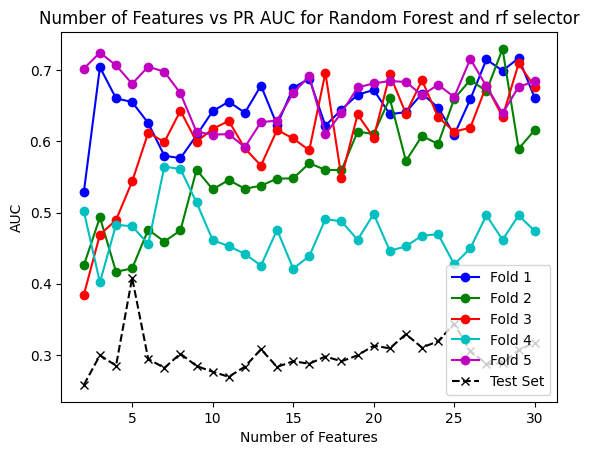

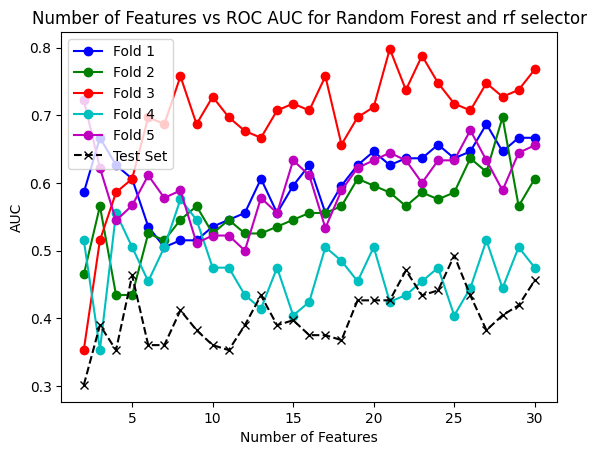

Starting with the 0 fold
(2455, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.591e+02, tolerance: 6.012e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

fine 0 fold
Starting with the 1 fold
(2552, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.728e+02, tolerance: 6.277e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

fine 1 fold
Starting with the 2 fold
(2618, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.829e+02, tolerance: 6.448e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

fine 2 fold
Starting with the 3 fold
(2497, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.746e+02, tolerance: 6.174e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

fine 3 fold
Starting with the 4 fold
(2610, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.835e+02, tolerance: 6.433e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

fine 4 fold
best_f1_indices prima volta  [ 6  7 10 11 12]
sto tagliando
best_f1_indices 2 volta  [10, 11, 12]
best_f1_indices 3 volta  [10, 11, 12]
best_f1_indices 4 volta  [10, 11, 12]
best index:  10
best_f1_indices prima volta  [ 4  6 18 19]
sto tagliando
best_f1_indices 2 volta  [18, 19]
best_f1_indices 3 volta  [18, 19]
best_f1_indices 4 volta  [18, 19]
best index:  18
best_f1_indices prima volta  [ 8  9 10]
sto tagliando
best_f1_indices 2 volta  [8, 9, 10]
best_f1_indices 3 volta  [8, 9, 10]
best_f1_indices 4 volta  [8, 9, 10]
best index:  8
best_f1_indices prima volta  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
sto tagliando
best_f1_indices 2 volta  [0]
best index:  0
best_f1_indices prima volta  [ 5  6  7  8  9 10]
sto tagliando
best_f1_indices 2 volta  [5, 6, 7, 8, 9, 10]
best_f1_indices 3 volta  [5, 6, 7, 8, 9, 10]
best_f1_indices 4 volta  [5, 6, 7, 8, 9, 10]
best index:  5
The mean best threshold for lasso is: 0.33019999999999994
(3183, 32)
Removed feature

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.499e+02, tolerance: 7.837e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Results obtained with the best mean parameters on the test set for lasso and rf classifier 

alpha:  0.002589473684210526
threshold:  0.33019999999999994
F1 score:  0.5333333333333333
best_precision:  0.36363636363636365
best_recall:  1.0
confusion matrix :  [[ 3 14]
 [ 0  8]]
test_accuracy:  0.44
pr_auc:  0.28254502259436465
roc_auc:  0.38602941176470595


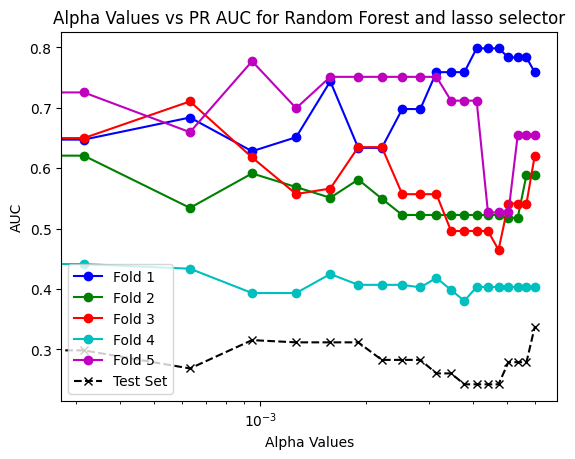

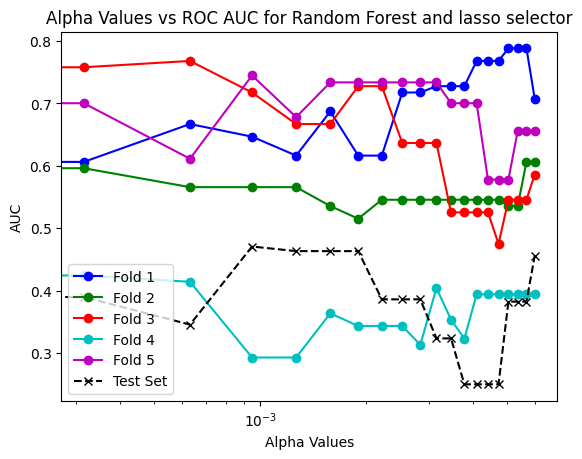

Starting with the 0 fold
(2455, 32)
Removed features: ['feature_14', 'feature_23']
fine 0 fold
Starting with the 1 fold
(2552, 32)
Removed features: ['feature_14', 'feature_23']
fine 1 fold
Starting with the 2 fold
(2618, 32)
Removed features: ['feature_14', 'feature_23']
fine 2 fold
Starting with the 3 fold
(2497, 32)
Removed features: ['feature_14', 'feature_23']
fine 3 fold
Starting with the 4 fold
(2610, 32)
Removed features: ['feature_14', 'feature_23']
fine 4 fold
best_f1_indices prima volta  [0]
best index:  0
best_f1_indices prima volta  [ 6 23]
sto tagliando
best_f1_indices 2 volta  [23]
best index:  23
best_f1_indices prima volta  [21]
best index:  21
best_f1_indices prima volta  [0]
best index:  0
best_f1_indices prima volta  [5 7]
sto tagliando
best_f1_indices 2 volta  [7]
best index:  7
The mean best threshold for logistic is: 0.42400000000000004
(3183, 32)
Removed features: ['feature_14', 'feature_23']
Features:  12.2
threshold:  0.42400000000000004
Results obtained with 

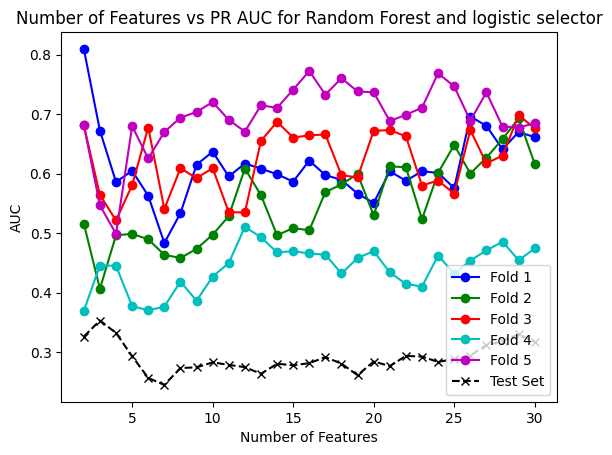

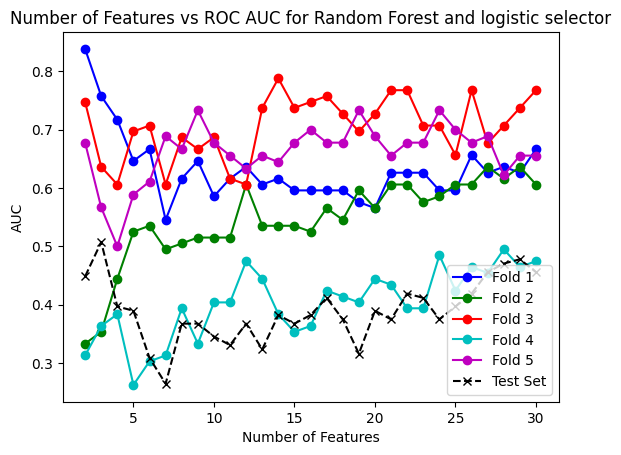

In [218]:
kf = StratifiedKFold(n_splits=num_folds)

results_test_rf={}
results_rf = [{} for _ in range(num_folds)]

for selector in selectors: 
    i = 0
    results_test_rf[selector] = {
            'alpha': [],
            'num_features': [],
            'pr_auc': [],
            'best_precision' :[],
            'best_recall':[],
            'roc_auc':[],
            'f1':[],
            'accuracy':[],
            'confusion_matrix':[],
            'best_threshold':[]
            }

    for train_index, val_index in kf.split(features_train1, y_train1):
    #for i in range (0,1):
        print(f"Starting with the {i} fold")
        ## creazione fold
        features_train = []
        features_val = []
        
        
        for idx in train_index:
            features=[]
            for x in range(len(features_train1[idx])):
                features.append(features_train1[idx][x])
            features=np.array(features)
            features_train.append(features)
            
        j=0
        for idx in val_index:
            features=[]
            for x in range(len(features_train1[idx])):
                features.append(features_train1[idx][x])
            features=np.array(features)
            features_val.append(features)

        y_train, y_val = y_train1[train_index], y_train1[val_index]
        patients_train, patients_val = patients_train1[train_index], patients_train1[val_index]

        ## fine creazione fold


        features=perform_correlation(features_train, y_train, 32, 0.85)

        final_patients_train=remove_features_from_patients(features_train, features)
        final_patients_test=remove_features_from_patients(features_test, features)
        final_patients_val=remove_features_from_patients(features_val, features)

        x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)

        results_rf[i][selector] = {
            'alpha': [],
            'num_features': [],
            'pr_auc': [],
            'best_precision' :[],
            'best_recall':[],
            'roc_auc':[],
            'f1':[],
            'accuracy':[],
            'confusion_matrix':[],
            'best_threshold':[]
            }
            

        if selector == 'lasso':
            for alpha in alpha_values:

                    rf = RandomForestClassifier(n_estimators=100, random_state=42)
                    best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                        selector, alpha, rf, x_train_expanded, y_train_expanded, 
                        patients_val, y_val, final_patients_val, 0
                    )
                
                    results_rf[i][selector]['alpha'].append(alpha)
                    results_rf[i][selector]['pr_auc'].append(pr_auc)
                    results_rf[i][selector]['best_precision'].append(best_precision)
                    results_rf[i][selector]['best_recall'].append(best_recall)
                    results_rf[i][selector]['roc_auc'].append(roc_auc)
                    results_rf[i][selector]['f1'].append(best_f1_score)
                    results_rf[i][selector]['accuracy'].append(test_accuracy)
                    results_rf[i][selector]['confusion_matrix'].append(conf)
                    results_rf[i][selector]['best_threshold'].append(bt)

                    # Plot dei risultati per 'lasso'
                    


        else:
                for t in range(2, len(x_train_expanded[0])+1):

                    rf = RandomForestClassifier(n_estimators=100, random_state=42)

                    best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                        selector, 0, rf, x_train_expanded, y_train_expanded, 
                        patients_val, y_val, final_patients_val, t
                    )
                    results_rf[i][selector]['num_features'].append(t)
                    results_rf[i][selector]['pr_auc'].append(pr_auc)
                    results_rf[i][selector]['best_precision'].append(best_precision)
                    results_rf[i][selector]['best_recall'].append(best_recall)
                    results_rf[i][selector]['roc_auc'].append(roc_auc)
                    results_rf[i][selector]['f1'].append(best_f1_score)
                    results_rf[i][selector]['accuracy'].append(test_accuracy)
                    results_rf[i][selector]['confusion_matrix'].append(conf)
                    results_rf[i][selector]['best_threshold'].append(bt)

        print(f"fine {i} fold")

        i=i+1

    mean_threshold, mean_param  = find_best_threshold_features(results_rf, selector)
    print(f"The mean best threshold for {selector} is: {mean_threshold}")

    ## faccio il train su tutto il dataset di train 
    features=perform_correlation(features_train1, y_train1, 32, 0.85)
    final_patients_train1=remove_features_from_patients(features_train1, features) ## quale correlation tengo??
    x_train_expanded1, y_train_expanded1, _ = continue_array(final_patients_train1, y_train1)
    

    if selector=='lasso':
        for alpha in alpha_values:
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                                selector, alpha, rf, x_train_expanded1, y_train_expanded1, 
                                patients_test, y_test, final_patients_test, 0, mean_threshold
                            )

            results_test_rf[selector]['alpha'].append(alpha)
            results_test_rf[selector]['pr_auc'].append(pr_auc)
            results_test_rf[selector]['best_precision'].append(best_precision)
            results_test_rf[selector]['best_recall'].append(best_recall)
            results_test_rf[selector]['roc_auc'].append(roc_auc)
            results_test_rf[selector]['f1'].append(best_f1_score)
            results_test_rf[selector]['accuracy'].append(test_accuracy)
            results_test_rf[selector]['confusion_matrix'].append(conf)
            results_test_rf[selector]['best_threshold'].append(bt)

        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                                selector, mean_param, rf, x_train_expanded1, y_train_expanded1, 
                                patients_test, y_test, final_patients_test, 0, mean_threshold
                            )
        print(f"Results obtained with the best mean parameters on the test set for lasso and rf classifier \n")
        print("alpha: ", mean_param)
        print("threshold: ", mean_threshold)
        print("F1 score: ", best_f1_score)
        print("best_precision: ", best_precision)
        print("best_recall: ", best_recall)
        print("confusion matrix : ", conf)
        print("test_accuracy: ", test_accuracy)
        print("pr_auc: ", pr_auc)
        print("roc_auc: ", roc_auc)
        

        


    else:

        for t in range(2, len(x_train_expanded[0])+1):
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                                selector, 0, rf, x_train_expanded1, y_train_expanded1, 
                                patients_test, y_test, final_patients_test, t, mean_threshold )

            results_test_rf[selector]['num_features'].append(t)
            results_test_rf[selector]['pr_auc'].append(pr_auc)
            results_test_rf[selector]['best_precision'].append(best_precision)
            results_test_rf[selector]['best_recall'].append(best_recall)
            results_test_rf[selector]['roc_auc'].append(roc_auc)
            results_test_rf[selector]['f1'].append(best_f1_score)
            results_test_rf[selector]['accuracy'].append(test_accuracy)
            results_test_rf[selector]['confusion_matrix'].append(conf)
            results_test_rf[selector]['best_threshold'].append(bt)

        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                                selector, mean_param, rf, x_train_expanded1, y_train_expanded1, 
                                patients_test, y_test, final_patients_test, 0, mean_threshold
                            )
        
        print(f"Results obtained with the best mean parameters on the test set for {selector} and rf classifier \n")
        print("Features: ", mean_param)
        print("threshold: ", mean_threshold)
        print("F1 score: ", best_f1_score)
        print("best_precision: ", best_precision)
        print("best_recall: ", best_recall)
        print("confusion matrix : ", conf)
        print("test_accuracy: ", test_accuracy)
        print("pr_auc: ", pr_auc)
        print("roc_auc: ", roc_auc)



    plot_results(results_rf, results_test_rf, selector)

        

## Confronto risultati

In [41]:
best_pr_auc_index = [{} for _ in range(num_folds)]
best_results = [{} for _ in range(num_folds)]

for i in range(num_folds):
    for selector in selectors:
        data = results_rf[i][selector]
        
        # Combina f1, pr_auc e gli indici originali in una lista di tuple
        combined = list(zip(data['f1'], data['pr_auc'], range(len(data['f1']))))
        
        # Ordina prima per f1 in ordine decrescente e poi per pr_auc in ordine decrescente
        sorted_combined = sorted(combined, key=lambda x: (-x[0], -x[1]))
        
        # Trova l'indice del miglior valore
        best_index = sorted_combined[0][2]
        
        # Salva l'indice del migliore pr_auc nel dizionario
        best_pr_auc_index[i][selector] = best_index
        
        # Salva i risultati migliori nel dizionario per i migliori risultati
        best_results[i][selector] = {key: data[key][best_index] for key in data.keys() if (selector == 'lasso' and key != 'num_features') or (selector != 'lasso' and key != 'alpha')}

        # Stampa tutti i valori associati a quell'indice
        print(f"Fold {i}, Per {selector}")
        for key in data.keys():
            if selector == "lasso":
                if key not in ['num_features']:
                    print(f"{key}: {data[key][best_index]}")
            else:
                if key not in ['alpha']:
                    print(f"{key}: {data[key][best_index]}")
        print()  # Stampa una linea vuota per separare i risultati

# best_pr_auc_index conterrà l'indice del miglior valore di f1 e pr_auc per ciascun selector in ogni fold
# best_results conterrà i risultati migliori per ciascun selector in ogni fold


Fold 0, Per lasso
alpha: 0.0
pr_auc: 0.5755555555555556
best_precision: 0.5
best_recall: 0.8
roc_auc: 0.676923076923077
f1: 0.6153846153846154
accuracy: 0.7222222222222222
confusion_matrix: [[9 4]
 [1 4]]
best_threshold: 0.5

Fold 0, Per rf
num_features: 51
pr_auc: 0.5755555555555556
best_precision: 0.5
best_recall: 0.8
roc_auc: 0.676923076923077
f1: 0.6153846153846154
accuracy: 0.7222222222222222
confusion_matrix: [[9 4]
 [1 4]]
best_threshold: 0.5

Fold 0, Per logistic
num_features: 51
pr_auc: 0.5755555555555556
best_precision: 0.5
best_recall: 0.8
roc_auc: 0.676923076923077
f1: 0.6153846153846154
accuracy: 0.7222222222222222
confusion_matrix: [[9 4]
 [1 4]]
best_threshold: 0.5

Fold 1, Per lasso
alpha: 0.0009473684210526316
pr_auc: 0.577056277056277
best_precision: 0.5333333333333333
best_recall: 1.0
roc_auc: 0.48611111111111116
f1: 0.6956521739130435
accuracy: 0.5882352941176471
confusion_matrix: [[2 7]
 [0 8]]
best_threshold: 0.46

Fold 1, Per rf
num_features: 2
pr_auc: 0.57404609

In [50]:
import numpy as np

# Supponiamo che tu abbia già creato e popolato il tuo array di dizionari results_rf
# results_rf = ... (Il tuo codice per creare e popolare questo array)

# Numero di fold (supponendo che tu l'abbia già definito)
num_folds = 5  # ad esempio

# Inizializza una struttura per i risultati medi
average_best_results = {
    selector: {
        'alpha': [],
        'num_features': [],
        'pr_auc': [],
        'best_precision': [],
        'best_recall': [],
        'roc_auc': [],
        'f1': [],
        'accuracy': [],
        'best_threshold': []
    }
    for selector in selectors
}

# Lista per mantenere i migliori risultati per ogni fold
best_pr_auc_index = [{} for _ in range(num_folds)]
best_results = [{} for _ in range(num_folds)]
num_features_best_per_fold = {selector: [] for selector in selectors if selector != 'lasso'}

# Trova i migliori risultati per ogni fold e selector
for i in range(num_folds):
    for selector in selectors:
        data = results_rf[i][selector]
        
        # Combina f1, pr_auc e gli indici originali in una lista di tuple
        combined = list(zip(data['f1'], data['pr_auc'], range(len(data['f1']))))
        
        # Ordina prima per f1 in ordine decrescente e poi per pr_auc in ordine decrescente
        sorted_combined = sorted(combined, key=lambda x: (-x[0], -x[1]))
        
        # Trova l'indice del miglior valore
        best_index = sorted_combined[0][2]
        
        # Salva l'indice del migliore pr_auc nel dizionario
        best_pr_auc_index[i][selector] = best_index
        
        # Salva i risultati migliori nel dizionario per i migliori risultati
        best_results[i][selector] = {key: data[key][best_index] for key in data.keys() if (selector == 'lasso' and key != 'num_features') or (selector != 'lasso' and key != 'alpha')}
        
        # Salva il numero di features migliori in un array separato
        if selector != 'lasso':
            num_features_best_per_fold[selector].append(data['num_features'][best_index])

# Calcola la media dei migliori risultati per ciascun selector
for selector in selectors:
    for key in average_best_results[selector].keys():
        # Verifica se 'key' è presente in almeno uno dei dizionari di best_results
        if all(key in best_results[i][selector] for i in range(num_folds)):
            values = [best_results[i][selector][key] for i in range(num_folds)]
            
            # Se abbiamo una lista di liste (come 'alpha'), calcoliamo la media per ogni posizione
            if isinstance(values[0], list):
                average_values = [np.mean([fold_values[j] for fold_values in values if len(fold_values) > j]) for j in range(max(len(fold_values) for fold_values in values))]
                average_best_results[selector][key] = average_values
            elif key != 'num_features':
                average_best_results[selector][key] = np.mean(values)
            
            # Stampa i risultati medi
            if key != 'num_features':
                print(f"Media dei migliori risultati per {selector} - {key}: {average_best_results[selector][key]}")
        else:
            continue
    
    # Stampa il numero di features migliori per ciascun fold
    if selector != 'lasso':
        print(f"Numero di features migliori per {selector} per ciascun fold: {num_features_best_per_fold[selector]}")
    print()  # Stampa una linea vuota per separare i risultati medi

# best_pr_auc_index conterrà l'indice del miglior valore di f1 e pr_auc per ciascun selector in ogni fold
# best_results conterrà i risultati migliori per ciascun selector in ogni fold
# num_features_best_per_fold conterrà il numero di features migliori per ciascun fold e selector (escluso 'lasso')


Media dei migliori risultati per lasso - alpha: 0.0009473684210526314
Media dei migliori risultati per lasso - pr_auc: 0.694994860648222
Media dei migliori risultati per lasso - best_precision: 0.6519949494949494
Media dei migliori risultati per lasso - best_recall: 0.9349999999999999
Media dei migliori risultati per lasso - roc_auc: 0.6857753357753358
Media dei migliori risultati per lasso - f1: 0.7617791405956147
Media dei migliori risultati per lasso - accuracy: 0.7444444444444442
Media dei migliori risultati per lasso - best_threshold: 0.42000000000000004

Media dei migliori risultati per rf - pr_auc: 0.7512532054779955
Media dei migliori risultati per rf - best_precision: 0.6532908268202385
Media dei migliori risultati per rf - best_recall: 0.9099999999999999
Media dei migliori risultati per rf - roc_auc: 0.748986568986569
Media dei migliori risultati per rf - f1: 0.7543467643467643
Media dei migliori risultati per rf - accuracy: 0.7444444444444445
Media dei migliori risultati per

## Loop per Logistic con grafici e risultati

Starting with the 0 fold
(2455, 32)
Removed features: ['feature_14', 'feature_23']


Starting with the 1 fold
(2552, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 2 fold
(2618, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 3 fold
(2497, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 4 fold
(2610, 32)
Removed features: ['feature_14', 'feature_23']
best_f1_indices prima volta  [7 8]
sto tagliando
best_f1_indices 2 volta  [8]
best index:  8
best_f1_indices prima volta  [8]
best index:  8
best_f1_indices prima volta  [ 5 21 26]
sto tagliando
best_f1_indices 2 volta  [5]
best index:  5
best_f1_indices prima volta  [24]
best index:  24
best_f1_indices prima volta  [0 1]
sto tagliando
best_f1_indices 2 volta  [0]
best index:  0
The mean best threshold for rf is: 0.472
(3183, 32)
Removed features: ['feature_14', 'feature_23']
Results obtained with the best mean parameters on the test set for rf and logistic classifier 

Features:  11.0
threshold:  0.472
F1 score:  0.36363636363636365
best_precision:  0.2857142

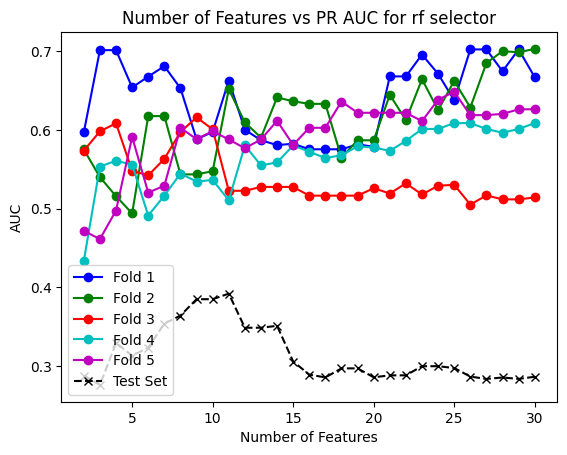

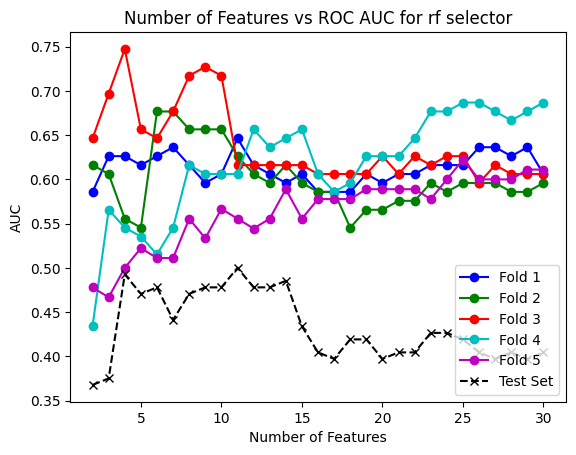

Starting with the 0 fold
(2455, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.591e+02, tolerance: 6.012e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 1 fold
(2552, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.728e+02, tolerance: 6.277e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 2 fold
(2618, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.829e+02, tolerance: 6.448e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 3 fold
(2497, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.746e+02, tolerance: 6.174e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 4 fold
(2610, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.835e+02, tolerance: 6.433e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

best_f1_indices prima volta  [19]
best index:  19
best_f1_indices prima volta  [18 19]
sto tagliando
best_f1_indices 2 volta  [18, 19]
best_f1_indices 3 volta  [18, 19]
best_f1_indices 4 volta  [18, 19]
best index:  18
best_f1_indices prima volta  [0 1 6 7]
sto tagliando
best_f1_indices 2 volta  [6, 7]
best_f1_indices 3 volta  [6, 7]
best_f1_indices 4 volta  [6, 7]
best index:  6
best_f1_indices prima volta  [1]
best index:  1
best_f1_indices prima volta  [ 5  6  7  8  9 10]
sto tagliando
best_f1_indices 2 volta  [5, 6, 7, 8, 9, 10]
best_f1_indices 3 volta  [5, 6, 7, 8, 9, 10]
best_f1_indices 4 volta  [5, 6, 7, 8, 9, 10]
best index:  5
The mean best threshold for lasso is: 0.4772
(3183, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.499e+02, tolerance: 7.837e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Results obtained with the best mean parameters on the test set for lasso and logistic classifier 

alpha:  0.0030947368421052634
threshold:  0.4772
F1 score:  0.36363636363636365
best_precision:  0.2857142857142857
best_recall:  0.5
confusion matrix :  [[ 7 10]
 [ 4  4]]
test_accuracy:  0.44
pr_auc:  0.3938842886652989
roc_auc:  0.5073529411764706


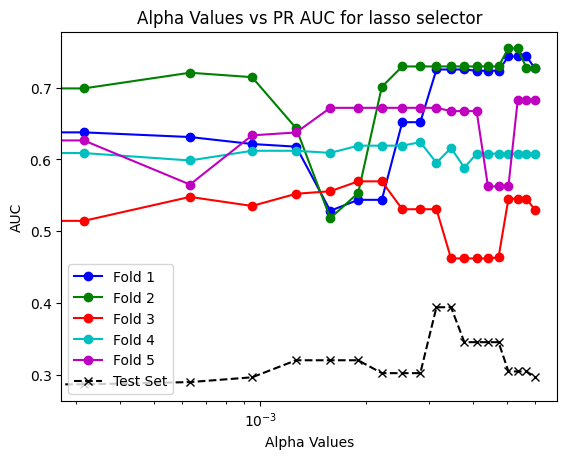

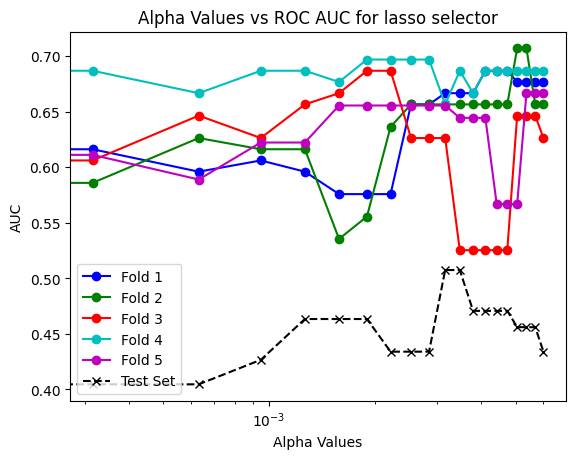

Starting with the 0 fold
(2455, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 1 fold
(2552, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 2 fold
(2618, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 3 fold
(2497, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 4 fold
(2610, 32)
Removed features: ['feature_14', 'feature_23']
best_f1_indices prima volta  [1]
best index:  1
best_f1_indices prima volta  [8]
best index:  8
best_f1_indices prima volta  [0]
best index:  0
best_f1_indices prima volta  [17]
best index:  17
best_f1_indices prima volta  [8]
best index:  8
The mean best threshold for logistic is: 0.47519999999999996
(3183, 32)
Removed features: ['feature_14', 'feature_23']
Results obtained with the best mean parameters on the test set for logistic and logistic classifier 

Features:  8.8
threshold:  0.47519999999999996
F1 score:  0.36363636363636365
best_precision:  0.2857142857142857
best_rec

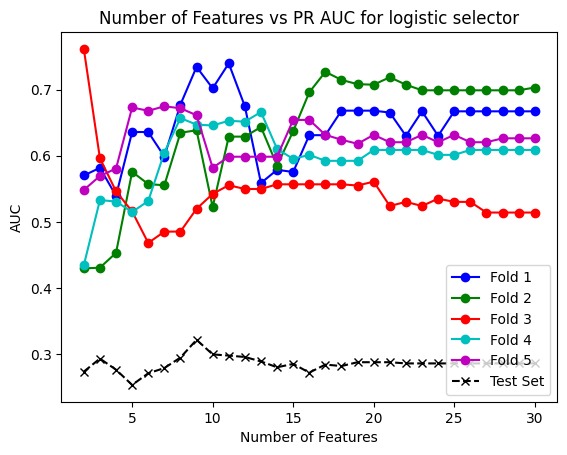

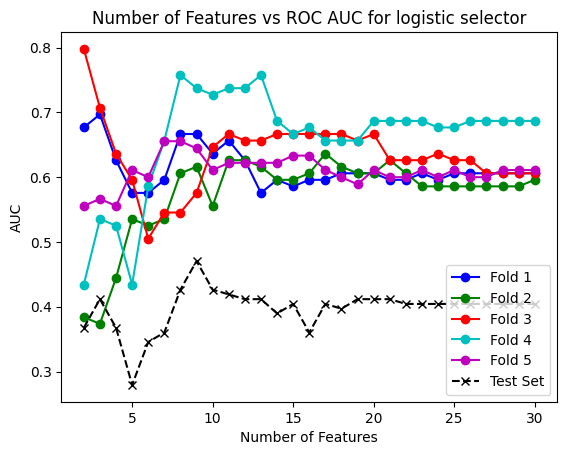

In [225]:
kf = StratifiedKFold(n_splits=num_folds)

results_test_logistic={}
results_logistic = [{} for _ in range(num_folds)]

for selector in selectors: 
    i = 0
    results_test_logistic[selector] = {
            'alpha': [],
            'num_features': [],
            'pr_auc': [],
            'best_precision' :[],
            'best_recall':[],
            'roc_auc':[],
            'f1':[],
            'accuracy':[],
            'confusion_matrix':[],
            'best_threshold':[]
            }

    for train_index, val_index in kf.split(features_train1, y_train1):
    #for i in range (0,1):
        print(f"Starting with the {i} fold")
        ## creazione fold
        features_train = []
        features_val = []
        
        
        for idx in train_index:
            features=[]
            for x in range(len(features_train1[idx])):
                features.append(features_train1[idx][x])
            features=np.array(features)
            features_train.append(features)
            
        j=0
        for idx in val_index:
            features=[]
            for x in range(len(features_train1[idx])):
                features.append(features_train1[idx][x])
            features=np.array(features)
            features_val.append(features)

        y_train, y_val = y_train1[train_index], y_train1[val_index]
        patients_train, patients_val = patients_train1[train_index], patients_train1[val_index]

        ## fine creazione fold


        features=perform_correlation(features_train, y_train, 32, 0.85)

        final_patients_train=remove_features_from_patients(features_train, features)
        final_patients_test=remove_features_from_patients(features_test, features)
        final_patients_val=remove_features_from_patients(features_val, features)

        x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)

        results_logistic[i][selector] = {
            'alpha': [],
            'num_features': [],
            'pr_auc': [],
            'best_precision' :[],
            'best_recall':[],
            'roc_auc':[],
            'f1':[],
            'accuracy':[],
            'confusion_matrix':[],
            'best_threshold':[]
            }
            

        if selector == 'lasso':
            for alpha in alpha_values:

                    logistic = LogisticRegression()
                    best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                        selector, alpha, logistic, x_train_expanded, y_train_expanded, 
                        patients_val, y_val, final_patients_val, 0
                    )
                
                    results_logistic[i][selector]['alpha'].append(alpha)
                    results_logistic[i][selector]['pr_auc'].append(pr_auc)
                    results_logistic[i][selector]['best_precision'].append(best_precision)
                    results_logistic[i][selector]['best_recall'].append(best_recall)
                    results_logistic[i][selector]['roc_auc'].append(roc_auc)
                    results_logistic[i][selector]['f1'].append(best_f1_score)
                    results_logistic[i][selector]['accuracy'].append(test_accuracy)
                    results_logistic[i][selector]['confusion_matrix'].append(conf)
                    results_logistic[i][selector]['best_threshold'].append(bt)

                    # Plot dei risultati per 'lasso'
                    


        else:
                for t in range(2, len(x_train_expanded[0])+1):

                    logistic = LogisticRegression()

                    best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                        selector, 0, logistic, x_train_expanded, y_train_expanded, 
                        patients_val, y_val, final_patients_val, t
                    )
                    results_logistic[i][selector]['num_features'].append(t)
                    results_logistic[i][selector]['pr_auc'].append(pr_auc)
                    results_logistic[i][selector]['best_precision'].append(best_precision)
                    results_logistic[i][selector]['best_recall'].append(best_recall)
                    results_logistic[i][selector]['roc_auc'].append(roc_auc)
                    results_logistic[i][selector]['f1'].append(best_f1_score)
                    results_logistic[i][selector]['accuracy'].append(test_accuracy)
                    results_logistic[i][selector]['confusion_matrix'].append(conf)
                    results_logistic[i][selector]['best_threshold'].append(bt)


        i=i+1

    mean_threshold, mean_param  = find_best_threshold_features(results_logistic, selector)
    print(f"The mean best threshold for {selector} is: {mean_threshold}")

    ## faccio il train su tutto il dataset di train 
    features=perform_correlation(features_train1, y_train1, 32, 0.85)
    final_patients_train1=remove_features_from_patients(features_train1, features) ## quale correlation tengo??
    x_train_expanded1, y_train_expanded1, _ = continue_array(final_patients_train1, y_train1)
    

    if selector=='lasso':
        for alpha in alpha_values:
            logistic = LogisticRegression()
            best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                                selector, alpha, logistic, x_train_expanded1, y_train_expanded1, 
                                patients_test, y_test, final_patients_test, 0, mean_threshold
                            )

            results_test_logistic[selector]['alpha'].append(alpha)
            results_test_logistic[selector]['pr_auc'].append(pr_auc)
            results_test_logistic[selector]['best_precision'].append(best_precision)
            results_test_logistic[selector]['best_recall'].append(best_recall)
            results_test_logistic[selector]['roc_auc'].append(roc_auc)
            results_test_logistic[selector]['f1'].append(best_f1_score)
            results_test_logistic[selector]['accuracy'].append(test_accuracy)
            results_test_logistic[selector]['confusion_matrix'].append(conf)
            results_test_logistic[selector]['best_threshold'].append(bt)

        logistic = LogisticRegression()
        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                                selector, mean_param, logistic, x_train_expanded1, y_train_expanded1, 
                                patients_test, y_test, final_patients_test, 0, mean_threshold
                            )
        print(f"Results obtained with the best mean parameters on the test set for lasso and logistic classifier \n")
        print("alpha: ", mean_param)
        print("threshold: ", mean_threshold)
        print("F1 score: ", best_f1_score)
        print("best_precision: ", best_precision)
        print("best_recall: ", best_recall)
        print("confusion matrix : ", conf)
        print("test_accuracy: ", test_accuracy)
        print("pr_auc: ", pr_auc)
        print("roc_auc: ", roc_auc)
        

        


    else:

        for t in range(2, len(x_train_expanded[0])+1):
            logistic = LogisticRegression()
            best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                                selector, 0, logistic, x_train_expanded1, y_train_expanded1, 
                                patients_test, y_test, final_patients_test, t, mean_threshold )

            results_test_logistic[selector]['num_features'].append(t)
            results_test_logistic[selector]['pr_auc'].append(pr_auc)
            results_test_logistic[selector]['best_precision'].append(best_precision)
            results_test_logistic[selector]['best_recall'].append(best_recall)
            results_test_logistic[selector]['roc_auc'].append(roc_auc)
            results_test_logistic[selector]['f1'].append(best_f1_score)
            results_test_logistic[selector]['accuracy'].append(test_accuracy)
            results_test_logistic[selector]['confusion_matrix'].append(conf)
            results_test_logistic[selector]['best_threshold'].append(bt)

        logistic = LogisticRegression()
        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                                selector, mean_param, logistic, x_train_expanded1, y_train_expanded1, 
                                patients_test, y_test, final_patients_test, 0, mean_threshold
                            )
        
        print(f"Results obtained with the best mean parameters on the test set for {selector} and logistic classifier \n")
        print("Features: ", mean_param)
        print("threshold: ", mean_threshold)
        print("F1 score: ", best_f1_score)
        print("best_precision: ", best_precision)
        print("best_recall: ", best_recall)
        print("confusion matrix : ", conf)
        print("test_accuracy: ", test_accuracy)
        print("pr_auc: ", pr_auc)
        print("roc_auc: ", roc_auc)



    plot_results(results_logistic, results_test_logistic, selector)

        

## Loop per MLP

Starting with the 0 fold
(2455, 32)
Removed features: ['feature_14', 'feature_23']
fine 0 fold
Starting with the 1 fold
(2552, 32)
Removed features: ['feature_14', 'feature_23']
fine 1 fold
Starting with the 2 fold
(2618, 32)
Removed features: ['feature_14', 'feature_23']
fine 2 fold
Starting with the 3 fold
(2497, 32)
Removed features: ['feature_14', 'feature_23']
fine 3 fold
Starting with the 4 fold
(2610, 32)
Removed features: ['feature_14', 'feature_23']
fine 4 fold
best_f1_indices prima volta  [14]
best index:  14
best_f1_indices prima volta  [ 0 24]
sto tagliando
best_f1_indices 2 volta  [0]
best index:  0
best_f1_indices prima volta  [10]
best index:  10
best_f1_indices prima volta  [12]
best index:  12
best_f1_indices prima volta  [19]
best index:  19
The mean best threshold for rf is: 0.3946
(3183, 32)
Removed features: ['feature_14', 'feature_23']
Results obtained with the best mean parameters on the test set for rf and mlp classifier 

Features:  13.0
threshold:  0.3946
F1 s

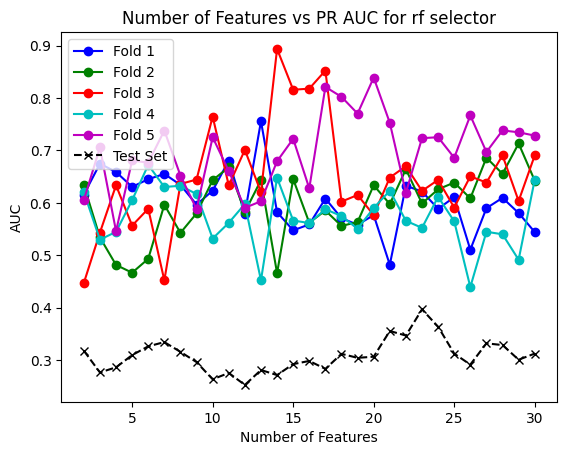

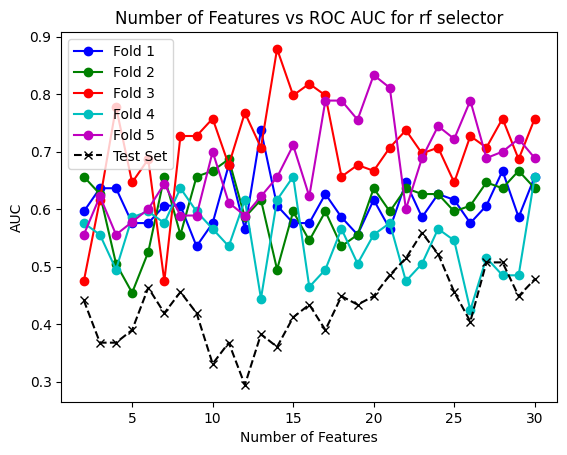

Starting with the 0 fold
(2455, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.591e+02, tolerance: 6.012e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

fine 0 fold
Starting with the 1 fold
(2552, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.728e+02, tolerance: 6.277e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

fine 1 fold
Starting with the 2 fold
(2618, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.829e+02, tolerance: 6.448e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

fine 2 fold
Starting with the 3 fold
(2497, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.746e+02, tolerance: 6.174e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

fine 3 fold
Starting with the 4 fold
(2610, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.835e+02, tolerance: 6.433e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

fine 4 fold
best_f1_indices prima volta  [19]
best index:  19
best_f1_indices prima volta  [16 17]
sto tagliando
best_f1_indices 2 volta  [16, 17]
best_f1_indices 3 volta  [16, 17]
best_f1_indices 4 volta  [16, 17]
best index:  16
best_f1_indices prima volta  [4]
best index:  4
best_f1_indices prima volta  [ 5  9 11 12 13 14 15 16 17 18 19]
sto tagliando
best_f1_indices 2 volta  [13, 14, 15, 16, 17, 18, 19]
best_f1_indices 3 volta  [13, 14, 15, 16, 17, 18, 19]
best_f1_indices 4 volta  [13, 14, 15, 16, 17, 18, 19]
best index:  13
best_f1_indices prima volta  [3]
best index:  3
The mean best threshold for lasso is: 0.421
(3183, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.499e+02, tolerance: 7.837e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Results obtained with the best mean parameters on the test set for lasso and mlp classifier 

alpha:  0.0034736842105263155
threshold:  0.421
F1 score:  0.4
best_precision:  0.29411764705882354
best_recall:  0.625
confusion matrix :  [[ 5 12]
 [ 3  5]]
test_accuracy:  0.4
pr_auc:  0.2961528534338636
roc_auc:  0.4338235294117647


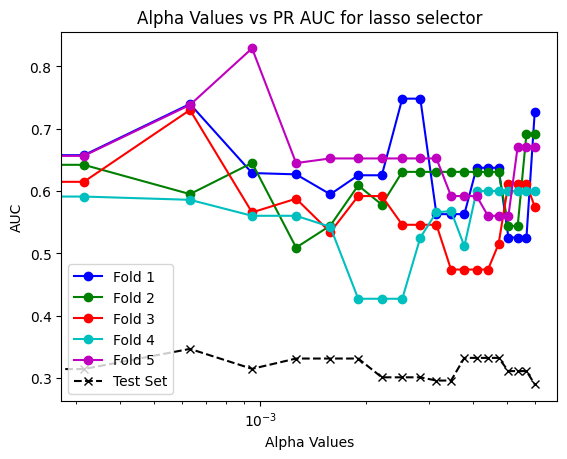

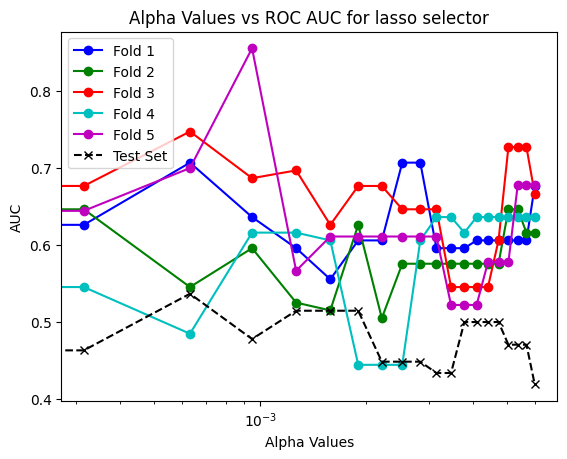

Starting with the 0 fold
(2455, 32)
Removed features: ['feature_14', 'feature_23']
fine 0 fold
Starting with the 1 fold
(2552, 32)
Removed features: ['feature_14', 'feature_23']
fine 1 fold
Starting with the 2 fold
(2618, 32)
Removed features: ['feature_14', 'feature_23']
fine 2 fold
Starting with the 3 fold
(2497, 32)
Removed features: ['feature_14', 'feature_23']
fine 3 fold
Starting with the 4 fold
(2610, 32)
Removed features: ['feature_14', 'feature_23']
fine 4 fold
best_f1_indices prima volta  [20]
best index:  20
best_f1_indices prima volta  [ 6 18 23 24 28]
sto tagliando
best_f1_indices 2 volta  [18]
best index:  18
best_f1_indices prima volta  [ 0 11 18]
sto tagliando
best_f1_indices 2 volta  [0]
best index:  0
best_f1_indices prima volta  [0 1 4]
sto tagliando
best_f1_indices 2 volta  [1]
best index:  1
best_f1_indices prima volta  [18 19 21]
sto tagliando
best_f1_indices 2 volta  [18]
best index:  18
The mean best threshold for logistic is: 0.42960000000000004
(3183, 32)
Remo

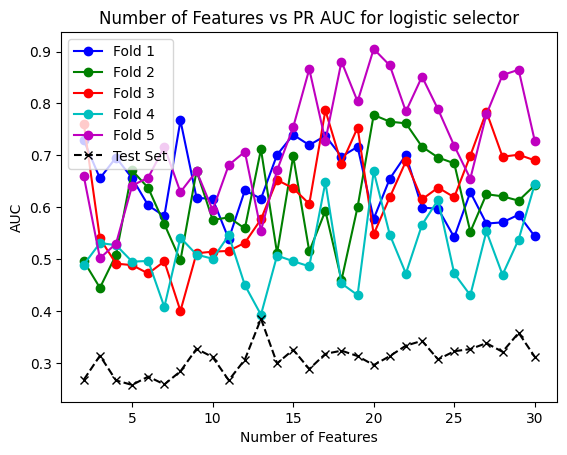

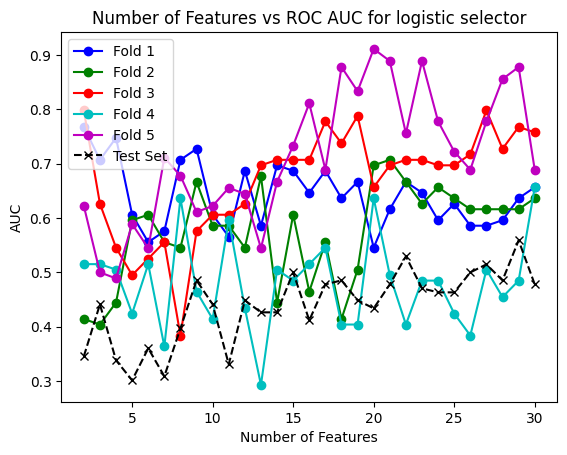

In [226]:
kf = StratifiedKFold(n_splits=num_folds)

results_test_mlp={}
results_mlp = [{} for _ in range(num_folds)]

for selector in selectors: 
    i = 0
    results_test_mlp[selector] = {
            'alpha': [],
            'num_features': [],
            'pr_auc': [],
            'best_precision' :[],
            'best_recall':[],
            'roc_auc':[],
            'f1':[],
            'accuracy':[],
            'confusion_matrix':[],
            'best_threshold':[]
            }

    for train_index, val_index in kf.split(features_train1, y_train1):
    #for i in range (0,1):
        print(f"Starting with the {i} fold")
        ## creazione fold
        features_train = []
        features_val = []
        
        
        for idx in train_index:
            features=[]
            for x in range(len(features_train1[idx])):
                features.append(features_train1[idx][x])
            features=np.array(features)
            features_train.append(features)
            
        j=0
        for idx in val_index:
            features=[]
            for x in range(len(features_train1[idx])):
                features.append(features_train1[idx][x])
            features=np.array(features)
            features_val.append(features)

        y_train, y_val = y_train1[train_index], y_train1[val_index]
        patients_train, patients_val = patients_train1[train_index], patients_train1[val_index]

        ## fine creazione fold


        features=perform_correlation(features_train, y_train, 32, 0.85)

        final_patients_train=remove_features_from_patients(features_train, features)
        final_patients_test=remove_features_from_patients(features_test, features)
        final_patients_val=remove_features_from_patients(features_val, features)

        x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)

        results_mlp[i][selector] = {
            'alpha': [],
            'num_features': [],
            'pr_auc': [],
            'best_precision' :[],
            'best_recall':[],
            'roc_auc':[],
            'f1':[],
            'accuracy':[],
            'confusion_matrix':[],
            'best_threshold':[]
            }
            

        if selector == 'lasso':
            for alpha in alpha_values:

                    classifier = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                    best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                        selector, alpha, classifier, x_train_expanded, y_train_expanded, 
                        patients_val, y_val, final_patients_val, 0
                    )
                
                    results_mlp[i][selector]['alpha'].append(alpha)
                    results_mlp[i][selector]['pr_auc'].append(pr_auc)
                    results_mlp[i][selector]['best_precision'].append(best_precision)
                    results_mlp[i][selector]['best_recall'].append(best_recall)
                    results_mlp[i][selector]['roc_auc'].append(roc_auc)
                    results_mlp[i][selector]['f1'].append(best_f1_score)
                    results_mlp[i][selector]['accuracy'].append(test_accuracy)
                    results_mlp[i][selector]['confusion_matrix'].append(conf)
                    results_mlp[i][selector]['best_threshold'].append(bt)

                    # Plot dei risultati per 'lasso'
                    


        else:
                for t in range(2, len(x_train_expanded[0])+1):

                    classifier = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')

                    best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                        selector, 0, classifier, x_train_expanded, y_train_expanded, 
                        patients_val, y_val, final_patients_val, t
                    )
                    results_mlp[i][selector]['num_features'].append(t)
                    results_mlp[i][selector]['pr_auc'].append(pr_auc)
                    results_mlp[i][selector]['best_precision'].append(best_precision)
                    results_mlp[i][selector]['best_recall'].append(best_recall)
                    results_mlp[i][selector]['roc_auc'].append(roc_auc)
                    results_mlp[i][selector]['f1'].append(best_f1_score)
                    results_mlp[i][selector]['accuracy'].append(test_accuracy)
                    results_mlp[i][selector]['confusion_matrix'].append(conf)
                    results_mlp[i][selector]['best_threshold'].append(bt)

        print(f"fine {i} fold")

        i=i+1

    mean_threshold, mean_param  = find_best_threshold_features(results_mlp, selector)
    print(f"The mean best threshold for {selector} is: {mean_threshold}")

    ## faccio il train su tutto il dataset di train 
    features=perform_correlation(features_train1, y_train1, 32, 0.85)
    final_patients_train1=remove_features_from_patients(features_train1, features) ## quale correlation tengo??
    x_train_expanded1, y_train_expanded1, _ = continue_array(final_patients_train1, y_train1)
    

    if selector=='lasso':
        for alpha in alpha_values:
            classifier = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
            best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                                selector, alpha, classifier, x_train_expanded1, y_train_expanded1, 
                                patients_test, y_test, final_patients_test, 0, mean_threshold
                            )

            results_test_mlp[selector]['alpha'].append(alpha)
            results_test_mlp[selector]['pr_auc'].append(pr_auc)
            results_test_mlp[selector]['best_precision'].append(best_precision)
            results_test_mlp[selector]['best_recall'].append(best_recall)
            results_test_mlp[selector]['roc_auc'].append(roc_auc)
            results_test_mlp[selector]['f1'].append(best_f1_score)
            results_test_mlp[selector]['accuracy'].append(test_accuracy)
            results_test_mlp[selector]['confusion_matrix'].append(conf)
            results_test_mlp[selector]['best_threshold'].append(bt)

        classifier = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                                selector, mean_param, classifier, x_train_expanded1, y_train_expanded1, 
                                patients_test, y_test, final_patients_test, 0, mean_threshold
                            )
        print(f"Results obtained with the best mean parameters on the test set for lasso and mlp classifier \n")
        print("alpha: ", mean_param)
        print("threshold: ", mean_threshold)
        print("F1 score: ", best_f1_score)
        print("best_precision: ", best_precision)
        print("best_recall: ", best_recall)
        print("confusion matrix : ", conf)
        print("test_accuracy: ", test_accuracy)
        print("pr_auc: ", pr_auc)
        print("roc_auc: ", roc_auc)
        

        


    else:

        for t in range(2, len(x_train_expanded[0])+1):
            classifier = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
            best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                                selector, 0, classifier, x_train_expanded1, y_train_expanded1, 
                                patients_test, y_test, final_patients_test, t, mean_threshold )

            results_test_mlp[selector]['num_features'].append(t)
            results_test_mlp[selector]['pr_auc'].append(pr_auc)
            results_test_mlp[selector]['best_precision'].append(best_precision)
            results_test_mlp[selector]['best_recall'].append(best_recall)
            results_test_mlp[selector]['roc_auc'].append(roc_auc)
            results_test_mlp[selector]['f1'].append(best_f1_score)
            results_test_mlp[selector]['accuracy'].append(test_accuracy)
            results_test_mlp[selector]['confusion_matrix'].append(conf)
            results_test_mlp[selector]['best_threshold'].append(bt)

        classifier = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                                selector, mean_param, classifier, x_train_expanded1, y_train_expanded1, 
                                patients_test, y_test, final_patients_test, 0, mean_threshold
                            )
        
        print(f"Results obtained with the best mean parameters on the test set for {selector} and mlp classifier \n")
        print("Features: ", mean_param)
        print("threshold: ", mean_threshold)
        print("F1 score: ", best_f1_score)
        print("best_precision: ", best_precision)
        print("best_recall: ", best_recall)
        print("confusion matrix : ", conf)
        print("test_accuracy: ", test_accuracy)
        print("pr_auc: ", pr_auc)
        print("roc_auc: ", roc_auc)



    plot_results(results_mlp, results_test_mlp, selector)

        

## Loop per SVM

Starting with the 0 fold
(2455, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 1 fold
(2552, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 2 fold
(2618, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 3 fold
(2497, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 4 fold
(2610, 32)
Removed features: ['feature_14', 'feature_23']
best_f1_indices prima volta  [22 23 24 25 26 27 28]
sto tagliando
best_f1_indices 2 volta  [27]
best index:  27
best_f1_indices prima volta  [1]
best index:  1
best_f1_indices prima volta  [19]
best index:  19
best_f1_indices prima volta  [0]
best index:  0
best_f1_indices prima volta  [16]
best index:  16
The mean best threshold for rf is: 0.392
(3183, 32)
Removed features: ['feature_14', 'feature_23']
Results obtained with the best mean parameters on the test set for rf and svm classifier 

Features:  14.6
threshold:  0.392
F1 score:  0.38095238095238093
best_precision:  0.307

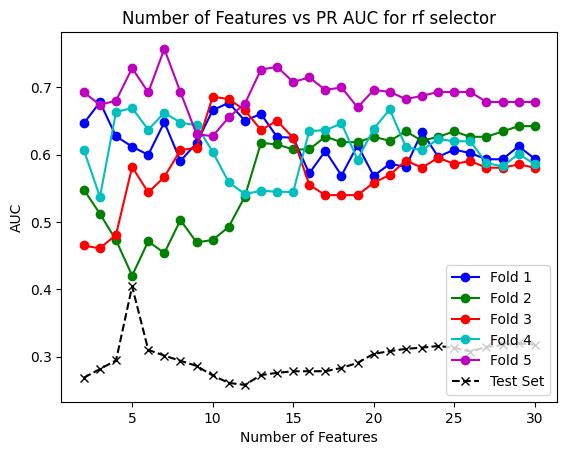

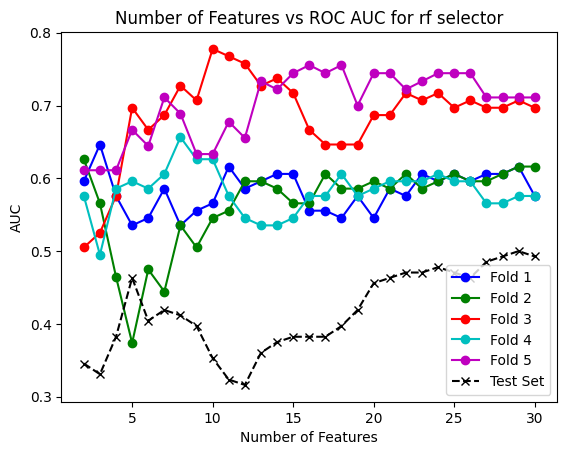

Starting with the 0 fold
(2455, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.591e+02, tolerance: 6.012e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 1 fold
(2552, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.728e+02, tolerance: 6.277e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 2 fold
(2618, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.829e+02, tolerance: 6.448e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 3 fold
(2497, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.746e+02, tolerance: 6.174e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 4 fold
(2610, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.835e+02, tolerance: 6.433e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

best_f1_indices prima volta  [0]
best index:  0
best_f1_indices prima volta  [7]
best index:  7
best_f1_indices prima volta  [1]
best index:  1
best_f1_indices prima volta  [13 14 15 16 17 18 19]
sto tagliando
best_f1_indices 2 volta  [13, 14, 15, 16, 17, 18, 19]
best_f1_indices 3 volta  [13, 14, 15, 16, 17, 18, 19]
best_f1_indices 4 volta  [13, 14, 15, 16, 17, 18, 19]
best index:  13
best_f1_indices prima volta  [1 3]
sto tagliando
best_f1_indices 2 volta  [3]
best index:  3
The mean best threshold for lasso is: 0.3554
(3183, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.499e+02, tolerance: 7.837e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Results obtained with the best mean parameters on the test set for lasso and svm classifier 

alpha:  0.0015157894736842104
threshold:  0.3554
F1 score:  0.48
best_precision:  0.35294117647058826
best_recall:  0.75
confusion matrix :  [[ 6 11]
 [ 2  6]]
test_accuracy:  0.48
pr_auc:  0.3367965367965368
roc_auc:  0.5147058823529411


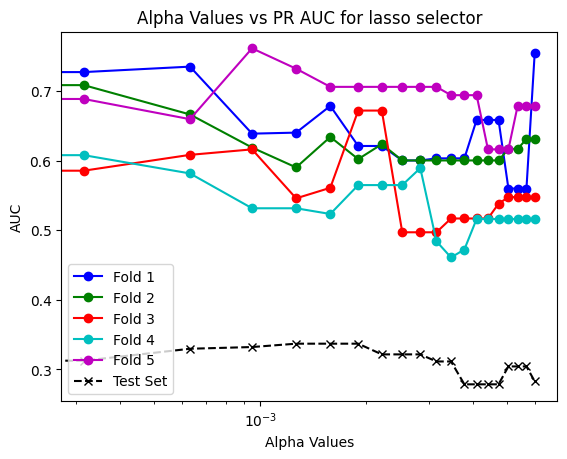

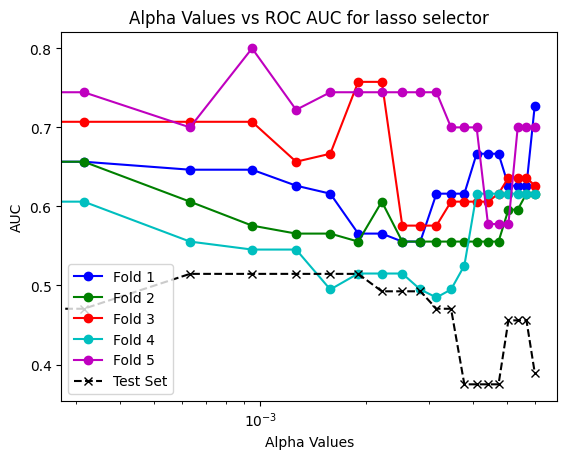

Starting with the 0 fold
(2455, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 1 fold
(2552, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 2 fold
(2618, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 3 fold
(2497, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 4 fold
(2610, 32)
Removed features: ['feature_14', 'feature_23']
best_f1_indices prima volta  [0 1]
sto tagliando
best_f1_indices 2 volta  [0]
best index:  0
best_f1_indices prima volta  [23]
best index:  23
best_f1_indices prima volta  [0]
best index:  0
best_f1_indices prima volta  [6]
best index:  6
best_f1_indices prima volta  [15]
best index:  15
The mean best threshold for logistic is: 0.4626
(3183, 32)
Removed features: ['feature_14', 'feature_23']
Results obtained with the best mean parameters on the test set for logistic and svm classifier 

Features:  10.8
threshold:  0.4626
F1 score:  0.25
best_precision:  0.25
best_recall:  0.25
c

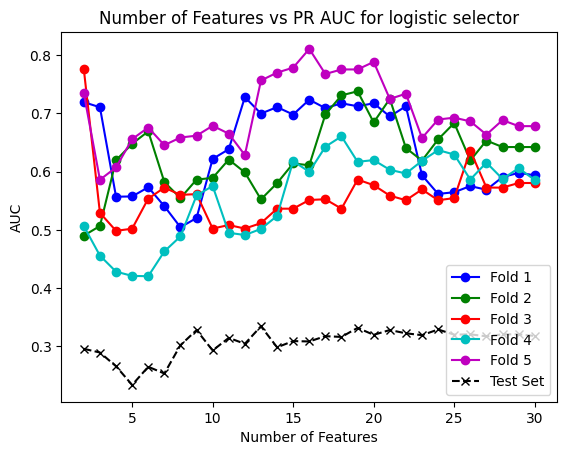

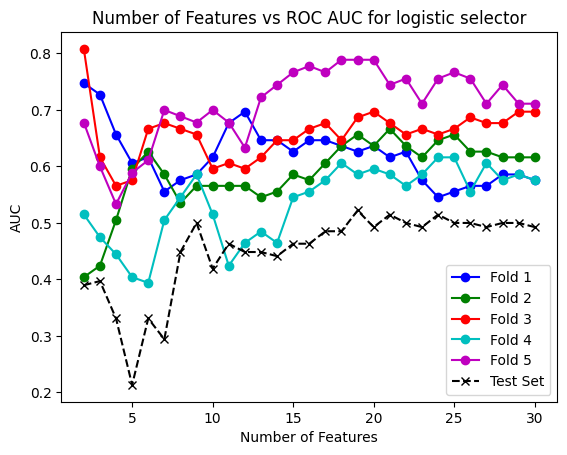

In [227]:
kf = StratifiedKFold(n_splits=num_folds)

results_test_svm={}
results_svm = [{} for _ in range(num_folds)]

for selector in selectors: 
    i = 0
    results_test_svm[selector] = {
            'alpha': [],
            'num_features': [],
            'pr_auc': [],
            'best_precision' :[],
            'best_recall':[],
            'roc_auc':[],
            'f1':[],
            'accuracy':[],
            'confusion_matrix':[],
            'best_threshold':[]
            }

    for train_index, val_index in kf.split(features_train1, y_train1):
    #for i in range (0,1):
        print(f"Starting with the {i} fold")
        ## creazione fold
        features_train = []
        features_val = []
        
        
        for idx in train_index:
            features=[]
            for x in range(len(features_train1[idx])):
                features.append(features_train1[idx][x])
            features=np.array(features)
            features_train.append(features)
            
        j=0
        for idx in val_index:
            features=[]
            for x in range(len(features_train1[idx])):
                features.append(features_train1[idx][x])
            features=np.array(features)
            features_val.append(features)

        y_train, y_val = y_train1[train_index], y_train1[val_index]
        patients_train, patients_val = patients_train1[train_index], patients_train1[val_index]

        ## fine creazione fold


        features=perform_correlation(features_train, y_train, 32, 0.85)

        final_patients_train=remove_features_from_patients(features_train, features)
        final_patients_test=remove_features_from_patients(features_test, features)
        final_patients_val=remove_features_from_patients(features_val, features)

        x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)

        results_svm[i][selector] = {
            'alpha': [],
            'num_features': [],
            'pr_auc': [],
            'best_precision' :[],
            'best_recall':[],
            'roc_auc':[],
            'f1':[],
            'accuracy':[],
            'confusion_matrix':[],
            'best_threshold':[]
            }
            

        if selector == 'lasso':
            for alpha in alpha_values:

                    classifier = SVC(kernel='rbf', probability=True, random_state=42)
                    best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                        selector, alpha, classifier, x_train_expanded, y_train_expanded, 
                        patients_val, y_val, final_patients_val, 0
                    )
                
                    results_svm[i][selector]['alpha'].append(alpha)
                    results_svm[i][selector]['pr_auc'].append(pr_auc)
                    results_svm[i][selector]['best_precision'].append(best_precision)
                    results_svm[i][selector]['best_recall'].append(best_recall)
                    results_svm[i][selector]['roc_auc'].append(roc_auc)
                    results_svm[i][selector]['f1'].append(best_f1_score)
                    results_svm[i][selector]['accuracy'].append(test_accuracy)
                    results_svm[i][selector]['confusion_matrix'].append(conf)
                    results_svm[i][selector]['best_threshold'].append(bt)

                    # Plot dei risultati per 'lasso'
                    


        else:
                for t in range(2, len(x_train_expanded[0])+1):

                    classifier = SVC(kernel='rbf', probability=True, random_state=42)

                    best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                        selector, 0, classifier, x_train_expanded, y_train_expanded, 
                        patients_val, y_val, final_patients_val, t
                    )
                    results_svm[i][selector]['num_features'].append(t)
                    results_svm[i][selector]['pr_auc'].append(pr_auc)
                    results_svm[i][selector]['best_precision'].append(best_precision)
                    results_svm[i][selector]['best_recall'].append(best_recall)
                    results_svm[i][selector]['roc_auc'].append(roc_auc)
                    results_svm[i][selector]['f1'].append(best_f1_score)
                    results_svm[i][selector]['accuracy'].append(test_accuracy)
                    results_svm[i][selector]['confusion_matrix'].append(conf)
                    results_svm[i][selector]['best_threshold'].append(bt)

        i=i+1

    mean_threshold, mean_param  = find_best_threshold_features(results_svm, selector)
    print(f"The mean best threshold for {selector} is: {mean_threshold}")

    ## faccio il train su tutto il dataset di train 
    features=perform_correlation(features_train1, y_train1, 32, 0.85)
    final_patients_train1=remove_features_from_patients(features_train1, features) ## quale correlation tengo??
    x_train_expanded1, y_train_expanded1, _ = continue_array(final_patients_train1, y_train1)
    

    if selector=='lasso':
        for alpha in alpha_values:
            classifier = SVC(kernel='rbf', probability=True, random_state=42)
            best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                                selector, alpha, classifier, x_train_expanded1, y_train_expanded1, 
                                patients_test, y_test, final_patients_test, 0, mean_threshold
                            )

            results_test_svm[selector]['alpha'].append(alpha)
            results_test_svm[selector]['pr_auc'].append(pr_auc)
            results_test_svm[selector]['best_precision'].append(best_precision)
            results_test_svm[selector]['best_recall'].append(best_recall)
            results_test_svm[selector]['roc_auc'].append(roc_auc)
            results_test_svm[selector]['f1'].append(best_f1_score)
            results_test_svm[selector]['accuracy'].append(test_accuracy)
            results_test_svm[selector]['confusion_matrix'].append(conf)
            results_test_svm[selector]['best_threshold'].append(bt)

        classifier = SVC(kernel='rbf', probability=True, random_state=42)
        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                                selector, mean_param, classifier, x_train_expanded1, y_train_expanded1, 
                                patients_test, y_test, final_patients_test, 0, mean_threshold
                            )
        print(f"Results obtained with the best mean parameters on the test set for lasso and svm classifier \n")
        print("alpha: ", mean_param)
        print("threshold: ", mean_threshold)
        print("F1 score: ", best_f1_score)
        print("best_precision: ", best_precision)
        print("best_recall: ", best_recall)
        print("confusion matrix : ", conf)
        print("test_accuracy: ", test_accuracy)
        print("pr_auc: ", pr_auc)
        print("roc_auc: ", roc_auc)
        

        
    else:

        for t in range(2, len(x_train_expanded[0])+1):
            classifier = SVC(kernel='rbf', probability=True, random_state=42)
            best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                                selector, 0, classifier, x_train_expanded1, y_train_expanded1, 
                                patients_test, y_test, final_patients_test, t, mean_threshold )

            results_test_svm[selector]['num_features'].append(t)
            results_test_svm[selector]['pr_auc'].append(pr_auc)
            results_test_svm[selector]['best_precision'].append(best_precision)
            results_test_svm[selector]['best_recall'].append(best_recall)
            results_test_svm[selector]['roc_auc'].append(roc_auc)
            results_test_svm[selector]['f1'].append(best_f1_score)
            results_test_svm[selector]['accuracy'].append(test_accuracy)
            results_test_svm[selector]['confusion_matrix'].append(conf)
            results_test_svm[selector]['best_threshold'].append(bt)

        classifier = SVC(kernel='rbf', probability=True, random_state=42)
        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                                selector, mean_param, classifier, x_train_expanded1, y_train_expanded1, 
                                patients_test, y_test, final_patients_test, 0, mean_threshold
                            )
        
        print(f"Results obtained with the best mean parameters on the test set for {selector} and svm classifier \n")
        print("Features: ", mean_param)
        print("threshold: ", mean_threshold)
        print("F1 score: ", best_f1_score)
        print("best_precision: ", best_precision)
        print("best_recall: ", best_recall)
        print("confusion matrix : ", conf)
        print("test_accuracy: ", test_accuracy)
        print("pr_auc: ", pr_auc)
        print("roc_auc: ", roc_auc)



    plot_results(results_svm, results_test_svm, selector)

        

## Loop per xgboost

Starting with the 0 fold
(2455, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 1 fold
(2552, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 2 fold
(2618, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 3 fold
(2497, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 4 fold
(2610, 32)
Removed features: ['feature_14', 'feature_23']
best_f1_indices prima volta  [1]
best index:  1
best_f1_indices prima volta  [8]
best index:  8
best_f1_indices prima volta  [6 7]
sto tagliando
best_f1_indices 2 volta  [7]
best index:  7
best_f1_indices prima volta  [2]
best index:  2
best_f1_indices prima volta  [13 26]
sto tagliando
best_f1_indices 2 volta  [26]
best index:  26
The mean best threshold for rf is: 0.3408
(3183, 32)
Removed features: ['feature_14', 'feature_23']
Results obtained with the best mean parameters on the test set for rf and xgb classifier 

Features:  10.8
threshold:  0.3408
F1 score:  0.3
best_preci

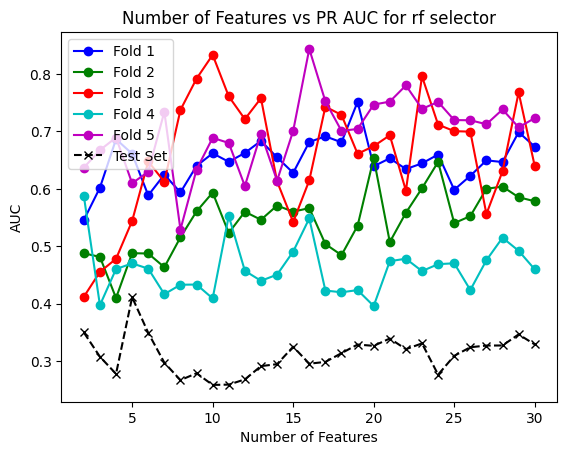

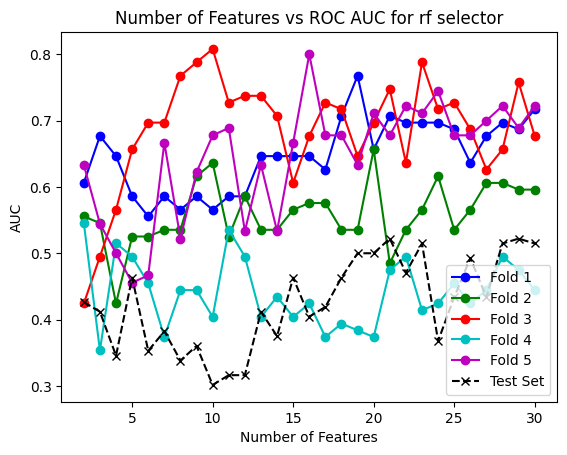

Starting with the 0 fold
(2455, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.591e+02, tolerance: 6.012e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 1 fold
(2552, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.728e+02, tolerance: 6.277e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 2 fold
(2618, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.829e+02, tolerance: 6.448e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 3 fold
(2497, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.746e+02, tolerance: 6.174e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 4 fold
(2610, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.835e+02, tolerance: 6.433e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

best_f1_indices prima volta  [19]
best index:  19
best_f1_indices prima volta  [1]
best index:  1
best_f1_indices prima volta  [ 4  8  9 10]
sto tagliando
best_f1_indices 2 volta  [4]
best index:  4
best_f1_indices prima volta  [13 14 15 16 17 18 19]
sto tagliando
best_f1_indices 2 volta  [13, 14, 15, 16, 17, 18, 19]
best_f1_indices 3 volta  [13, 14, 15, 16, 17, 18, 19]
best_f1_indices 4 volta  [13, 14, 15, 16, 17, 18, 19]
best index:  13
best_f1_indices prima volta  [1]
best index:  1
The mean best threshold for lasso is: 0.3762
(3183, 32)
Removed features: ['feature_14', 'feature_23']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.499e+02, tolerance: 7.837e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Results obtained with the best mean parameters on the test set for lasso and xgb classifier 

alpha:  0.0024000000000000002
threshold:  0.3762
F1 score:  0.4
best_precision:  0.3333333333333333
best_recall:  0.5
confusion matrix :  [[9 8]
 [4 4]]
test_accuracy:  0.52
pr_auc:  0.30168775970406403
roc_auc:  0.4411764705882353


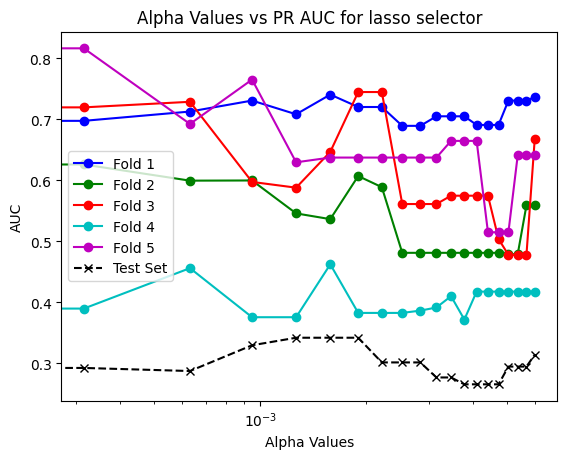

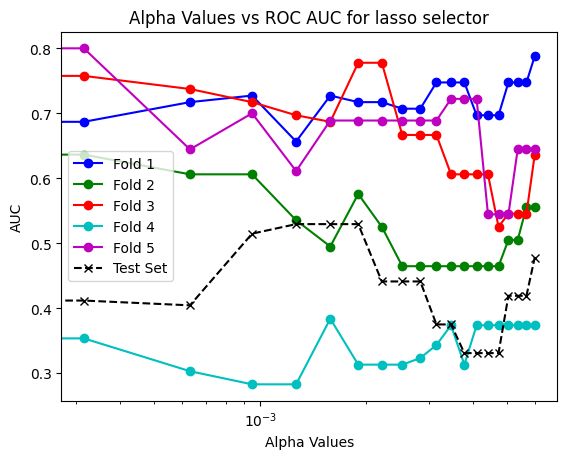

Starting with the 0 fold
(2455, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 1 fold
(2552, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 2 fold
(2618, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 3 fold
(2497, 32)
Removed features: ['feature_14', 'feature_23']
Starting with the 4 fold
(2610, 32)
Removed features: ['feature_14', 'feature_23']
best_f1_indices prima volta  [0]
best index:  0
best_f1_indices prima volta  [4]
best index:  4
best_f1_indices prima volta  [14]
best index:  14
best_f1_indices prima volta  [14]
best index:  14
best_f1_indices prima volta  [17]
best index:  17
The mean best threshold for logistic is: 0.3246
(3183, 32)
Removed features: ['feature_14', 'feature_23']
Results obtained with the best mean parameters on the test set for logistic and xgb classifier 

Features:  11.8
threshold:  0.3246
F1 score:  0.47619047619047616
best_precision:  0.38461538461538464
best_recall:  0.625
confusion mat

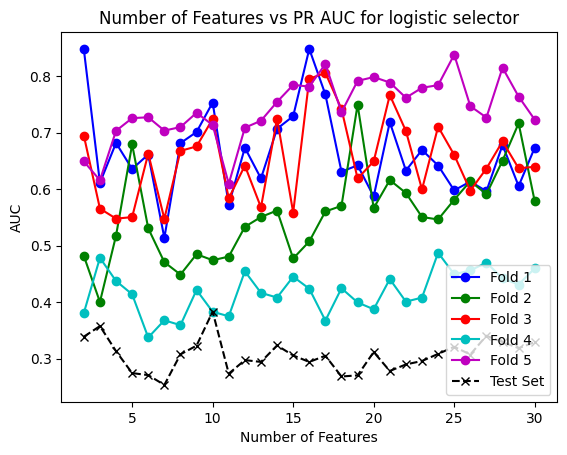

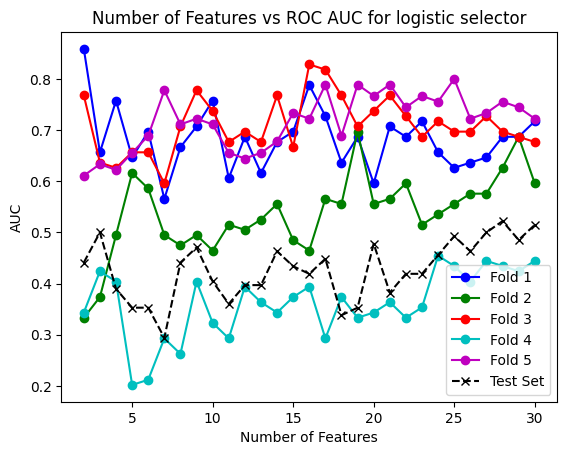

In [228]:
kf = StratifiedKFold(n_splits=num_folds)

results_test_xgb={}
results_xgb = [{} for _ in range(num_folds)]

for selector in selectors: 
    i = 0
    results_test_xgb[selector] = {
            'alpha': [],
            'num_features': [],
            'pr_auc': [],
            'best_precision' :[],
            'best_recall':[],
            'roc_auc':[],
            'f1':[],
            'accuracy':[],
            'confusion_matrix':[],
            'best_threshold':[]
            }

    for train_index, val_index in kf.split(features_train1, y_train1):
    #for i in range (0,1):
        print(f"Starting with the {i} fold")
        ## creazione fold
        features_train = []
        features_val = []
        
        
        for idx in train_index:
            features=[]
            for x in range(len(features_train1[idx])):
                features.append(features_train1[idx][x])
            features=np.array(features)
            features_train.append(features)
            
        j=0
        for idx in val_index:
            features=[]
            for x in range(len(features_train1[idx])):
                features.append(features_train1[idx][x])
            features=np.array(features)
            features_val.append(features)

        y_train, y_val = y_train1[train_index], y_train1[val_index]
        patients_train, patients_val = patients_train1[train_index], patients_train1[val_index]

        ## fine creazione fold


        features=perform_correlation(features_train, y_train, 32, 0.85)

        final_patients_train=remove_features_from_patients(features_train, features)
        final_patients_test=remove_features_from_patients(features_test, features)
        final_patients_val=remove_features_from_patients(features_val, features)

        x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)

        results_xgb[i][selector] = {
            'alpha': [],
            'num_features': [],
            'pr_auc': [],
            'best_precision' :[],
            'best_recall':[],
            'roc_auc':[],
            'f1':[],
            'accuracy':[],
            'confusion_matrix':[],
            'best_threshold':[]
            }
            

        if selector == 'lasso':
            for alpha in alpha_values:

                    classifier = XGBClassifier()
                    best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                        selector, alpha, classifier, x_train_expanded, y_train_expanded, 
                        patients_val, y_val, final_patients_val, 0
                    )
                
                    results_xgb[i][selector]['alpha'].append(alpha)
                    results_xgb[i][selector]['pr_auc'].append(pr_auc)
                    results_xgb[i][selector]['best_precision'].append(best_precision)
                    results_xgb[i][selector]['best_recall'].append(best_recall)
                    results_xgb[i][selector]['roc_auc'].append(roc_auc)
                    results_xgb[i][selector]['f1'].append(best_f1_score)
                    results_xgb[i][selector]['accuracy'].append(test_accuracy)
                    results_xgb[i][selector]['confusion_matrix'].append(conf)
                    results_xgb[i][selector]['best_threshold'].append(bt)

                    # Plot dei risultati per 'lasso'
                    


        else:
                for t in range(2, len(x_train_expanded[0])+1):

                    classifier = XGBClassifier()

                    best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                        selector, 0, classifier, x_train_expanded, y_train_expanded, 
                        patients_val, y_val, final_patients_val, t
                    )
                    results_xgb[i][selector]['num_features'].append(t)
                    results_xgb[i][selector]['pr_auc'].append(pr_auc)
                    results_xgb[i][selector]['best_precision'].append(best_precision)
                    results_xgb[i][selector]['best_recall'].append(best_recall)
                    results_xgb[i][selector]['roc_auc'].append(roc_auc)
                    results_xgb[i][selector]['f1'].append(best_f1_score)
                    results_xgb[i][selector]['accuracy'].append(test_accuracy)
                    results_xgb[i][selector]['confusion_matrix'].append(conf)
                    results_xgb[i][selector]['best_threshold'].append(bt)

        i=i+1

    mean_threshold, mean_param  = find_best_threshold_features(results_xgb, selector)
    print(f"The mean best threshold for {selector} is: {mean_threshold}")

    ## faccio il train su tutto il dataset di train 
    features=perform_correlation(features_train1, y_train1, 32, 0.85)
    final_patients_train1=remove_features_from_patients(features_train1, features) ## quale correlation tengo??
    x_train_expanded1, y_train_expanded1, _ = continue_array(final_patients_train1, y_train1)
    

    if selector=='lasso':
        for alpha in alpha_values:
            classifier = XGBClassifier()
            best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                                selector, alpha, classifier, x_train_expanded1, y_train_expanded1, 
                                patients_test, y_test, final_patients_test, 0, mean_threshold
                            )

            results_test_xgb[selector]['alpha'].append(alpha)
            results_test_xgb[selector]['pr_auc'].append(pr_auc)
            results_test_xgb[selector]['best_precision'].append(best_precision)
            results_test_xgb[selector]['best_recall'].append(best_recall)
            results_test_xgb[selector]['roc_auc'].append(roc_auc)
            results_test_xgb[selector]['f1'].append(best_f1_score)
            results_test_xgb[selector]['accuracy'].append(test_accuracy)
            results_test_xgb[selector]['confusion_matrix'].append(conf)
            results_test_xgb[selector]['best_threshold'].append(bt)

        classifier = XGBClassifier()
        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                                selector, mean_param, classifier, x_train_expanded1, y_train_expanded1, 
                                patients_test, y_test, final_patients_test, 0, mean_threshold
                            )
        print(f"Results obtained with the best mean parameters on the test set for lasso and xgb classifier \n")
        print("alpha: ", mean_param)
        print("threshold: ", mean_threshold)
        print("F1 score: ", best_f1_score)
        print("best_precision: ", best_precision)
        print("best_recall: ", best_recall)
        print("confusion matrix : ", conf)
        print("test_accuracy: ", test_accuracy)
        print("pr_auc: ", pr_auc)
        print("roc_auc: ", roc_auc)
        

        
    else:

        for t in range(2, len(x_train_expanded[0])+1):
            classifier = XGBClassifier()
            best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                                selector, 0, classifier, x_train_expanded1, y_train_expanded1, 
                                patients_test, y_test, final_patients_test, t, mean_threshold )

            results_test_xgb[selector]['num_features'].append(t)
            results_test_xgb[selector]['pr_auc'].append(pr_auc)
            results_test_xgb[selector]['best_precision'].append(best_precision)
            results_test_xgb[selector]['best_recall'].append(best_recall)
            results_test_xgb[selector]['roc_auc'].append(roc_auc)
            results_test_xgb[selector]['f1'].append(best_f1_score)
            results_test_xgb[selector]['accuracy'].append(test_accuracy)
            results_test_xgb[selector]['confusion_matrix'].append(conf)
            results_test_xgb[selector]['best_threshold'].append(bt)

        classifier = XGBClassifier()
        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt= classification_method1(
                                selector, mean_param, classifier, x_train_expanded1, y_train_expanded1, 
                                patients_test, y_test, final_patients_test, 0, mean_threshold
                            )
        
        print(f"Results obtained with the best mean parameters on the test set for {selector} and xgb classifier \n")
        print("Features: ", mean_param)
        print("threshold: ", mean_threshold)
        print("F1 score: ", best_f1_score)
        print("best_precision: ", best_precision)
        print("best_recall: ", best_recall)
        print("confusion matrix : ", conf)
        print("test_accuracy: ", test_accuracy)
        print("pr_auc: ", pr_auc)
        print("roc_auc: ", roc_auc)



    plot_results(results_xgb, results_test_xgb, selector)

        

# codice vecchio

## Loop per rf e stratified Kfold

In [99]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np


# Inizializza una struttura per i risultati
results_rf = [{} for _ in range(num_folds)]
for i in range(num_folds):
    for selector in selectors:
        results_rf[i][selector] = {
            'alpha': None,
            'num_features': None,
            'pr_auc': None,
            'best_precision': None,
            'best_recall': None,
            'roc_auc': None,
            'f1': None,
            'accuracy': None,
            'confusion_matrix': None,
            'best_threshold': None
        }

kf = StratifiedKFold(n_splits=num_folds)

i = 0
for train_index, val_index in kf.split(features_train1, y_train1):
    print(f"Starting with the {i} fold")
    ## creazione fold
    features_train = []
    features_val = []
    
    for idx in train_index:
        features = np.array(features_train1[idx])
        features_train.append(features)
        
    for idx in val_index:
        features = np.array(features_train1[idx])
        features_val.append(features)

    y_train, y_val = y_train1[train_index], y_train1[val_index]
    patients_train, patients_val = patients_train1[train_index], patients_train1[val_index]

    ## fine creazione fold

    features = perform_correlation(features_train, y_train, 64, 0.85)
    print(features)

    final_patients_train = remove_features_from_patients(features_train, features)
    final_patients_val = remove_features_from_patients(features_val, features)
    final_patients_test = remove_features_from_patients(features_test, features)

    x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)

    for selector in selectors:
        best_result = None  # Inizializza il miglior risultato

        if selector == 'lasso':
            for alpha in alpha_values:
                rf = RandomForestClassifier(n_estimators=100, random_state=42)
                best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt = classification_method1(
                    selector, alpha, rf, x_train_expanded, y_train_expanded, 
                    patients_val, y_val, final_patients_val, 0
                )
                
                current_result = {
                    'alpha': alpha,
                    'num_features': None,
                    'pr_auc': pr_auc,
                    'best_precision': best_precision,
                    'best_recall': best_recall,
                    'roc_auc': roc_auc,
                    'f1': best_f1_score,
                    'accuracy': test_accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': bt
                }

                if (best_result is None or
                    (best_f1_score > best_result['f1']) or
                    (best_f1_score == best_result['f1'] and pr_auc > best_result['pr_auc']) or
                    (best_f1_score == best_result['f1'] and pr_auc == best_result['pr_auc'] and test_accuracy > best_result['accuracy'])):
                    best_result = current_result

        else:
            for t in range(2, len(x_train_expanded[0]) + 1):
                rf = RandomForestClassifier(n_estimators=100, random_state=42)
                best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt = classification_method1(
                    selector, 0, rf, x_train_expanded, y_train_expanded, 
                    patients_val, y_val, final_patients_val, t
                )
                
                current_result = {
                    'alpha': None,
                    'num_features': t,
                    'pr_auc': pr_auc,
                    'best_precision': best_precision,
                    'best_recall': best_recall,
                    'roc_auc': roc_auc,
                    'f1': best_f1_score,
                    'accuracy': test_accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': bt
                }

                if (best_result is None or
                    (best_f1_score > best_result['f1']) or
                    (best_f1_score == best_result['f1'] and pr_auc > best_result['pr_auc']) or
                    (best_f1_score == best_result['f1'] and pr_auc == best_result['pr_auc'] and test_accuracy > best_result['accuracy'])):
                    best_result = current_result

        # Salva il miglior risultato nel dizionario
        results_rf[i][selector] = best_result
    i += 1



Starting with the 0 fold
(2455, 64)
Removed features: ['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_22', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']
['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_22', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.441e+02, tolerance: 6.012e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 1 fold
(2552, 64)
Removed features: ['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_27', 'feature_59', 'feature_58']
['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_27', 'feature_59', 'feature_58']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.609e+02, tolerance: 6.277e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 2 fold
(2618, 64)
Removed features: ['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']
['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.654e+02, tolerance: 6.448e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 3 fold
(2497, 64)
Removed features: ['feature_33', 'feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59', 'feature_58']
['feature_33', 'feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59', 'feature_58']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.544e+02, tolerance: 6.174e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 4 fold
(2610, 64)
Removed features: ['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']
['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.658e+02, tolerance: 6.433e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

In [84]:
# Dizionario per i risultati finali sul set di test
final_test_results = {selector: [] for selector in selectors}

# Test finale sul dataset di test con i parametri migliori trovati
for selector in selectors:
    for i in range(num_folds):
        best_alpha = results_rf[i][selector]['alpha']
        best_num_features = results_rf[i][selector]['num_features']
        best_threshold = results_rf[i][selector]['best_threshold']
        
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt = classification_method1(
            selector, best_alpha if best_alpha is not None else 0, rf, x_train_expanded, y_train_expanded, 
            patients_test, y_test, final_patients_test, best_num_features if best_num_features is not None else 0, best_threshold
        )
        
        test_result = {
            'alpha': best_alpha,
            'num_features': best_num_features,
            'pr_auc': pr_auc,
            'best_precision': best_precision,
            'best_recall': best_recall,
            'roc_auc': roc_auc,
            'f1': best_f1_score,
            'accuracy': test_accuracy,
            'confusion_matrix': conf,
            'best_threshold': bt
        }
        
        final_test_results[selector].append(test_result)
    
    print(f"Risultati finali sul test set per {selector}:")
    for result in final_test_results[selector]:
        print(result)
    print()

# final_test_results conterrà i risultati finali per ogni selector per ogni fold


[0.4]
[0.44]
[0.5]
[0.38]
[0.43]
Risultati finali sul test set per lasso:
{'alpha': 0.004736842105263158, 'num_features': None, 'pr_auc': 0.3127474473029938, 'best_precision': 0.30434782608695654, 'best_recall': 0.5833333333333334, 'roc_auc': 0.47756410256410253, 'f1': 0.4, 'accuracy': 0.4473684210526316, 'confusion_matrix': array([[10, 16],
       [ 5,  7]]), 'best_threshold': [0.4]}
{'alpha': 0.0050526315789473685, 'num_features': None, 'pr_auc': 0.33939617700750235, 'best_precision': 0.2857142857142857, 'best_recall': 0.5, 'roc_auc': 0.5224358974358974, 'f1': 0.36363636363636365, 'accuracy': 0.4473684210526316, 'confusion_matrix': array([[11, 15],
       [ 6,  6]]), 'best_threshold': [0.44]}
{'alpha': 0.002842105263157895, 'num_features': None, 'pr_auc': 0.35553083292963356, 'best_precision': 0.3333333333333333, 'best_recall': 0.4166666666666667, 'roc_auc': 0.5737179487179487, 'f1': 0.37037037037037035, 'accuracy': 0.5526315789473685, 'confusion_matrix': array([[16, 10],
       [ 7,

## Loop per Logistic

In [100]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import numpy as np


# Inizializza una struttura per i risultati
results_logistic = [{} for _ in range(num_folds)]
for i in range(num_folds):
    for selector in selectors:
        results_logistic[i][selector] = {
            'alpha': None,
            'num_features': None,
            'pr_auc': None,
            'best_precision': None,
            'best_recall': None,
            'roc_auc': None,
            'f1': None,
            'accuracy': None,
            'confusion_matrix': None,
            'best_threshold': None
        }

kf = StratifiedKFold(n_splits=num_folds)

i = 0
for train_index, val_index in kf.split(features_train1, y_train1):
    print(f"Starting with the {i} fold")
    ## creazione fold
    features_train = []
    features_val = []
    
    for idx in train_index:
        features = np.array(features_train1[idx])
        features_train.append(features)
        
    for idx in val_index:
        features = np.array(features_train1[idx])
        features_val.append(features)

    y_train, y_val = y_train1[train_index], y_train1[val_index]
    patients_train, patients_val = patients_train1[train_index], patients_train1[val_index]

    ## fine creazione fold

    features = perform_correlation(features_train, y_train, 64, 0.85)
    print(features)

    final_patients_train = remove_features_from_patients(features_train, features)
    final_patients_val = remove_features_from_patients(features_val, features)
    final_patients_test = remove_features_from_patients(features_test, features)

    x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)

    for selector in selectors:
        best_result = None  # Inizializza il miglior risultato

        if selector == 'lasso':
            for alpha in alpha_values:
                logistic = LogisticRegression()
                best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt = classification_method1(
                    selector, alpha, logistic, x_train_expanded, y_train_expanded, 
                    patients_val, y_val, final_patients_val, 0
                )
                
                current_result = {
                    'alpha': alpha,
                    'num_features': None,
                    'pr_auc': pr_auc,
                    'best_precision': best_precision,
                    'best_recall': best_recall,
                    'roc_auc': roc_auc,
                    'f1': best_f1_score,
                    'accuracy': test_accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': bt
                }

                if (best_result is None or
                    (best_f1_score > best_result['f1']) or
                    (best_f1_score == best_result['f1'] and pr_auc > best_result['pr_auc']) or
                    (best_f1_score == best_result['f1'] and pr_auc == best_result['pr_auc'] and test_accuracy > best_result['accuracy'])):
                    best_result = current_result

        else:
            for t in range(2, len(x_train_expanded[0]) + 1):
                logistic = LogisticRegression()
                best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt = classification_method1(
                    selector, 0, logistic, x_train_expanded, y_train_expanded, 
                    patients_val, y_val, final_patients_val, t
                )
                
                current_result = {
                    'alpha': None,
                    'num_features': t,
                    'pr_auc': pr_auc,
                    'best_precision': best_precision,
                    'best_recall': best_recall,
                    'roc_auc': roc_auc,
                    'f1': best_f1_score,
                    'accuracy': test_accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': bt
                }

                if (best_result is None or
                    (best_f1_score > best_result['f1']) or
                    (best_f1_score == best_result['f1'] and pr_auc > best_result['pr_auc']) or
                    (best_f1_score == best_result['f1'] and pr_auc == best_result['pr_auc'] and test_accuracy > best_result['accuracy'])):
                    best_result = current_result

        # Salva il miglior risultato nel dizionario
        results_logistic[i][selector] = best_result
    i += 1



Starting with the 0 fold
(2455, 64)
Removed features: ['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_22', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']
['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_22', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.441e+02, tolerance: 6.012e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Starting with the 1 fold
(2552, 64)
Removed features: ['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_27', 'feature_59', 'feature_58']
['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_27', 'feature_59', 'feature_58']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.609e+02, tolerance: 6.277e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 2 fold
(2618, 64)
Removed features: ['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']
['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.654e+02, tolerance: 6.448e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 3 fold
(2497, 64)
Removed features: ['feature_33', 'feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59', 'feature_58']
['feature_33', 'feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59', 'feature_58']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.544e+02, tolerance: 6.174e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 4 fold
(2610, 64)
Removed features: ['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']
['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.658e+02, tolerance: 6.433e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

In [89]:
# Dizionario per i risultati finali sul set di test
final_test_results = {selector: [] for selector in selectors}

# Test finale sul dataset di test con i parametri migliori trovati
for selector in selectors:
    for i in range(num_folds):
        best_alpha = results_logistic[i][selector]['alpha']
        best_num_features = results_logistic[i][selector]['num_features']
        best_threshold = results_logistic[i][selector]['best_threshold']
        
        logistic = LogisticRegression()
        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt = classification_method1(
            selector, best_alpha if best_alpha is not None else 0, logistic, x_train_expanded, y_train_expanded, 
            patients_test, y_test, final_patients_test, best_num_features if best_num_features is not None else 0, best_threshold
        )
        
        test_result = {
            'alpha': best_alpha,
            'num_features': best_num_features,
            'pr_auc': pr_auc,
            'best_precision': best_precision,
            'best_recall': best_recall,
            'roc_auc': roc_auc,
            'f1': best_f1_score,
            'accuracy': test_accuracy,
            'confusion_matrix': conf,
            'best_threshold': bt
        }
        
        final_test_results[selector].append(test_result)
    
    print(f"Risultati finali sul test set per {selector}:")
    for result in final_test_results[selector]:
        print(result)
    print()

# final_test_results conterrà i risultati finali per ogni selector per ogni fold


Risultati finali sul test set per lasso:
{'alpha': 0.0050526315789473685, 'num_features': None, 'pr_auc': 0.3171402199236951, 'best_precision': 0.3793103448275862, 'best_recall': 0.9166666666666666, 'roc_auc': 0.49358974358974356, 'f1': 0.5365853658536586, 'accuracy': 0.5, 'confusion_matrix': array([[ 8, 18],
       [ 1, 11]]), 'best_threshold': [0.421]}
{'alpha': 0.0015789473684210526, 'num_features': None, 'pr_auc': 0.3216803892458712, 'best_precision': 0.29411764705882354, 'best_recall': 0.4166666666666667, 'roc_auc': 0.49038461538461536, 'f1': 0.3448275862068966, 'accuracy': 0.5, 'confusion_matrix': array([[14, 12],
       [ 7,  5]]), 'best_threshold': [0.49]}
{'alpha': 0.005368421052631579, 'num_features': None, 'pr_auc': 0.3171402199236951, 'best_precision': 0.26666666666666666, 'best_recall': 0.3333333333333333, 'roc_auc': 0.49358974358974356, 'f1': 0.2962962962962963, 'accuracy': 0.5, 'confusion_matrix': array([[15, 11],
       [ 8,  4]]), 'best_threshold': [0.5]}
{'alpha': 0.0

## Loop per MLP

In [101]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import numpy as np


# Inizializza una struttura per i risultati
results_mlp = [{} for _ in range(num_folds)]
for i in range(num_folds):
    for selector in selectors:
        results_logistic[i][selector] = {
            'alpha': None,
            'num_features': None,
            'pr_auc': None,
            'best_precision': None,
            'best_recall': None,
            'roc_auc': None,
            'f1': None,
            'accuracy': None,
            'confusion_matrix': None,
            'best_threshold': None
        }

kf = StratifiedKFold(n_splits=num_folds)

i = 0
for train_index, val_index in kf.split(features_train1, y_train1):
    print(f"Starting with the {i} fold")
    ## creazione fold
    features_train = []
    features_val = []
    
    for idx in train_index:
        features = np.array(features_train1[idx])
        features_train.append(features)
        
    for idx in val_index:
        features = np.array(features_train1[idx])
        features_val.append(features)

    y_train, y_val = y_train1[train_index], y_train1[val_index]
    patients_train, patients_val = patients_train1[train_index], patients_train1[val_index]

    ## fine creazione fold

    features = perform_correlation(features_train, y_train, 64, 0.85)
    print(features)

    final_patients_train = remove_features_from_patients(features_train, features)
    final_patients_val = remove_features_from_patients(features_val, features)
    final_patients_test = remove_features_from_patients(features_test, features)

    x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)

    for selector in selectors:
        best_result = None  # Inizializza il miglior risultato

        if selector == 'lasso':
            for alpha in alpha_values:
                mlp = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt = classification_method1(
                    selector, alpha, mlp, x_train_expanded, y_train_expanded, 
                    patients_val, y_val, final_patients_val, 0
                )
                
                current_result = {
                    'alpha': alpha,
                    'num_features': None,
                    'pr_auc': pr_auc,
                    'best_precision': best_precision,
                    'best_recall': best_recall,
                    'roc_auc': roc_auc,
                    'f1': best_f1_score,
                    'accuracy': test_accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': bt
                }

                if (best_result is None or
                    (best_f1_score > best_result['f1']) or
                    (best_f1_score == best_result['f1'] and pr_auc > best_result['pr_auc']) or
                    (best_f1_score == best_result['f1'] and pr_auc == best_result['pr_auc'] and test_accuracy > best_result['accuracy'])):
                    best_result = current_result

        else:
            for t in range(2, len(x_train_expanded[0]) + 1):
                mlp = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt = classification_method1(
                    selector, 0, mlp, x_train_expanded, y_train_expanded, 
                    patients_val, y_val, final_patients_val, t
                )
                
                current_result = {
                    'alpha': None,
                    'num_features': t,
                    'pr_auc': pr_auc,
                    'best_precision': best_precision,
                    'best_recall': best_recall,
                    'roc_auc': roc_auc,
                    'f1': best_f1_score,
                    'accuracy': test_accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': bt
                }

                if (best_result is None or
                    (best_f1_score > best_result['f1']) or
                    (best_f1_score == best_result['f1'] and pr_auc > best_result['pr_auc']) or
                    (best_f1_score == best_result['f1'] and pr_auc == best_result['pr_auc'] and test_accuracy > best_result['accuracy'])):
                    best_result = current_result

        # Salva il miglior risultato nel dizionario
        results_mlp[i][selector] = best_result
    i += 1



Starting with the 0 fold
(2455, 64)
Removed features: ['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_22', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']
['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_22', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.441e+02, tolerance: 6.012e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 1 fold
(2552, 64)
Removed features: ['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_27', 'feature_59', 'feature_58']
['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_27', 'feature_59', 'feature_58']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.609e+02, tolerance: 6.277e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 2 fold
(2618, 64)
Removed features: ['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']
['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.654e+02, tolerance: 6.448e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 3 fold
(2497, 64)
Removed features: ['feature_33', 'feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59', 'feature_58']
['feature_33', 'feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59', 'feature_58']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.544e+02, tolerance: 6.174e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 4 fold
(2610, 64)
Removed features: ['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']
['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.658e+02, tolerance: 6.433e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

In [91]:
# Dizionario per i risultati finali sul set di test
final_test_results = {selector: [] for selector in selectors}

# Test finale sul dataset di test con i parametri migliori trovati
for selector in selectors:
    for i in range(num_folds):
        best_alpha = results_mlp[i][selector]['alpha']
        best_num_features = results_mlp[i][selector]['num_features']
        best_threshold = results_mlp[i][selector]['best_threshold']
        
        mlp = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt = classification_method1(
            selector, best_alpha if best_alpha is not None else 0, mlp, x_train_expanded, y_train_expanded, 
            patients_test, y_test, final_patients_test, best_num_features if best_num_features is not None else 0, best_threshold
        )
        
        test_result = {
            'alpha': best_alpha,
            'num_features': best_num_features,
            'pr_auc': pr_auc,
            'best_precision': best_precision,
            'best_recall': best_recall,
            'roc_auc': roc_auc,
            'f1': best_f1_score,
            'accuracy': test_accuracy,
            'confusion_matrix': conf,
            'best_threshold': bt
        }
        
        final_test_results[selector].append(test_result)
    
    print(f"Risultati finali sul test set per {selector}:")
    for result in final_test_results[selector]:
        print(result)
    print()

# final_test_results conterrà i risultati finali per ogni selector per ogni fold


Risultati finali sul test set per lasso:
{'alpha': 0.00031578947368421053, 'num_features': None, 'pr_auc': 0.3304887025094089, 'best_precision': 0.375, 'best_recall': 1.0, 'roc_auc': 0.5256410256410257, 'f1': 0.5454545454545454, 'accuracy': 0.47368421052631576, 'confusion_matrix': array([[ 6, 20],
       [ 0, 12]]), 'best_threshold': [0.225]}
{'alpha': 0.0050526315789473685, 'num_features': None, 'pr_auc': 0.3278915107515513, 'best_precision': 0.3, 'best_recall': 0.5, 'roc_auc': 0.4935897435897436, 'f1': 0.375, 'accuracy': 0.47368421052631576, 'confusion_matrix': array([[12, 14],
       [ 6,  6]]), 'best_threshold': [0.46]}
{'alpha': 0.002842105263157895, 'num_features': None, 'pr_auc': 0.39481130587296737, 'best_precision': 0.375, 'best_recall': 0.75, 'roc_auc': 0.6025641025641025, 'f1': 0.5, 'accuracy': 0.5263157894736842, 'confusion_matrix': array([[11, 15],
       [ 3,  9]]), 'best_threshold': [0.41000000000000003]}
{'alpha': 0.003157894736842105, 'num_features': None, 'pr_auc': 0.

## Loop per SVM

In [102]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import numpy as np


# Inizializza una struttura per i risultati
results_svm = [{} for _ in range(num_folds)]
for i in range(num_folds):
    for selector in selectors:
        results_logistic[i][selector] = {
            'alpha': None,
            'num_features': None,
            'pr_auc': None,
            'best_precision': None,
            'best_recall': None,
            'roc_auc': None,
            'f1': None,
            'accuracy': None,
            'confusion_matrix': None,
            'best_threshold': None
        }

kf = StratifiedKFold(n_splits=num_folds)

i = 0
for train_index, val_index in kf.split(features_train1, y_train1):
    print(f"Starting with the {i} fold")
    ## creazione fold
    features_train = []
    features_val = []
    
    for idx in train_index:
        features = np.array(features_train1[idx])
        features_train.append(features)
        
    for idx in val_index:
        features = np.array(features_train1[idx])
        features_val.append(features)

    y_train, y_val = y_train1[train_index], y_train1[val_index]
    patients_train, patients_val = patients_train1[train_index], patients_train1[val_index]

    ## fine creazione fold

    features = perform_correlation(features_train, y_train, 64, 0.85)
    print(features)

    final_patients_train = remove_features_from_patients(features_train, features)
    final_patients_val = remove_features_from_patients(features_val, features)
    final_patients_test = remove_features_from_patients(features_test, features)

    x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)

    for selector in selectors:
        best_result = None  # Inizializza il miglior risultato

        if selector == 'lasso':
            for alpha in alpha_values:
                svm = SVC(kernel='rbf', probability=True, random_state=42)
                best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt = classification_method1(
                    selector, alpha, svm, x_train_expanded, y_train_expanded, 
                    patients_val, y_val, final_patients_val, 0
                )
                
                current_result = {
                    'alpha': alpha,
                    'num_features': None,
                    'pr_auc': pr_auc,
                    'best_precision': best_precision,
                    'best_recall': best_recall,
                    'roc_auc': roc_auc,
                    'f1': best_f1_score,
                    'accuracy': test_accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': bt
                }

                if (best_result is None or
                    (best_f1_score > best_result['f1']) or
                    (best_f1_score == best_result['f1'] and pr_auc > best_result['pr_auc']) or
                    (best_f1_score == best_result['f1'] and pr_auc == best_result['pr_auc'] and test_accuracy > best_result['accuracy'])):
                    best_result = current_result

        else:
            for t in range(2, len(x_train_expanded[0]) + 1):
                svm = SVC(kernel='rbf', probability=True, random_state=42)
                best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt = classification_method1(
                    selector, 0, svm, x_train_expanded, y_train_expanded, 
                    patients_val, y_val, final_patients_val, t
                )
                
                current_result = {
                    'alpha': None,
                    'num_features': t,
                    'pr_auc': pr_auc,
                    'best_precision': best_precision,
                    'best_recall': best_recall,
                    'roc_auc': roc_auc,
                    'f1': best_f1_score,
                    'accuracy': test_accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': bt
                }

                if (best_result is None or
                    (best_f1_score > best_result['f1']) or
                    (best_f1_score == best_result['f1'] and pr_auc > best_result['pr_auc']) or
                    (best_f1_score == best_result['f1'] and pr_auc == best_result['pr_auc'] and test_accuracy > best_result['accuracy'])):
                    best_result = current_result

        # Salva il miglior risultato nel dizionario
        results_svm[i][selector] = best_result
    i += 1



Starting with the 0 fold
(2455, 64)
Removed features: ['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_22', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']
['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_22', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.441e+02, tolerance: 6.012e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 1 fold
(2552, 64)
Removed features: ['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_27', 'feature_59', 'feature_58']
['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_27', 'feature_59', 'feature_58']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.609e+02, tolerance: 6.277e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 2 fold
(2618, 64)
Removed features: ['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']
['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.654e+02, tolerance: 6.448e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 3 fold
(2497, 64)
Removed features: ['feature_33', 'feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59', 'feature_58']
['feature_33', 'feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59', 'feature_58']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.544e+02, tolerance: 6.174e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 4 fold
(2610, 64)
Removed features: ['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']
['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.658e+02, tolerance: 6.433e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

In [93]:
# Dizionario per i risultati finali sul set di test
final_test_results = {selector: [] for selector in selectors}

# Test finale sul dataset di test con i parametri migliori trovati
for selector in selectors:
    for i in range(num_folds):
        best_alpha = results_svm[i][selector]['alpha']
        best_num_features = results_svm[i][selector]['num_features']
        best_threshold = results_svm[i][selector]['best_threshold']
        
        svm = SVC(kernel='rbf', probability=True, random_state=42)
        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt = classification_method1(
            selector, best_alpha if best_alpha is not None else 0, svm, x_train_expanded, y_train_expanded, 
            patients_test, y_test, final_patients_test, best_num_features if best_num_features is not None else 0, best_threshold
        )
        
        test_result = {
            'alpha': best_alpha,
            'num_features': best_num_features,
            'pr_auc': pr_auc,
            'best_precision': best_precision,
            'best_recall': best_recall,
            'roc_auc': roc_auc,
            'f1': best_f1_score,
            'accuracy': test_accuracy,
            'confusion_matrix': conf,
            'best_threshold': bt
        }
        
        final_test_results[selector].append(test_result)
    
    print(f"Risultati finali sul test set per {selector}:")
    for result in final_test_results[selector]:
        print(result)
    print()

# final_test_results conterrà i risultati finali per ogni selector per ogni fold


Risultati finali sul test set per lasso:
{'alpha': 0.0012631578947368421, 'num_features': None, 'pr_auc': 0.3649368622479829, 'best_precision': 0.3076923076923077, 'best_recall': 0.6666666666666666, 'roc_auc': 0.532051282051282, 'f1': 0.42105263157894735, 'accuracy': 0.42105263157894735, 'confusion_matrix': array([[ 8, 18],
       [ 4,  8]]), 'best_threshold': [0.276]}
{'alpha': 0.0050526315789473685, 'num_features': None, 'pr_auc': 0.3459682352733456, 'best_precision': 0.3157894736842105, 'best_recall': 0.5, 'roc_auc': 0.46153846153846156, 'f1': 0.3870967741935484, 'accuracy': 0.5, 'confusion_matrix': array([[13, 13],
       [ 6,  6]]), 'best_threshold': [0.425]}
{'alpha': 0.00031578947368421053, 'num_features': None, 'pr_auc': 0.3394561251920123, 'best_precision': 0.3684210526315789, 'best_recall': 0.5833333333333334, 'roc_auc': 0.5192307692307692, 'f1': 0.45161290322580644, 'accuracy': 0.5526315789473685, 'confusion_matrix': array([[14, 12],
       [ 5,  7]]), 'best_threshold': [0.4

## Loop per xgboost

In [103]:
from xgboost import XGBClassifier

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import numpy as np


# Inizializza una struttura per i risultati
results_xgboost = [{} for _ in range(num_folds)]
for i in range(num_folds):
    for selector in selectors:
        results_logistic[i][selector] = {
            'alpha': None,
            'num_features': None,
            'pr_auc': None,
            'best_precision': None,
            'best_recall': None,
            'roc_auc': None,
            'f1': None,
            'accuracy': None,
            'confusion_matrix': None,
            'best_threshold': None
        }

kf = StratifiedKFold(n_splits=num_folds)

i = 0
for train_index, val_index in kf.split(features_train1, y_train1):
    print(f"Starting with the {i} fold")
    ## creazione fold
    features_train = []
    features_val = []
    
    for idx in train_index:
        features = np.array(features_train1[idx])
        features_train.append(features)
        
    for idx in val_index:
        features = np.array(features_train1[idx])
        features_val.append(features)

    y_train, y_val = y_train1[train_index], y_train1[val_index]
    patients_train, patients_val = patients_train1[train_index], patients_train1[val_index]

    ## fine creazione fold

    features = perform_correlation(features_train, y_train, 64, 0.85)
    print(features)

    final_patients_train = remove_features_from_patients(features_train, features)
    final_patients_val = remove_features_from_patients(features_val, features)
    final_patients_test = remove_features_from_patients(features_test, features)

    x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)

    for selector in selectors:
        best_result = None  # Inizializza il miglior risultato

        if selector == 'lasso':
            for alpha in alpha_values:
                xgb=XGBClassifier()
                best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt = classification_method1(
                    selector, alpha, xgb, x_train_expanded, y_train_expanded, 
                    patients_val, y_val, final_patients_val, 0
                )
                
                current_result = {
                    'alpha': alpha,
                    'num_features': None,
                    'pr_auc': pr_auc,
                    'best_precision': best_precision,
                    'best_recall': best_recall,
                    'roc_auc': roc_auc,
                    'f1': best_f1_score,
                    'accuracy': test_accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': bt
                }

                if (best_result is None or
                    (best_f1_score > best_result['f1']) or
                    (best_f1_score == best_result['f1'] and pr_auc > best_result['pr_auc']) or
                    (best_f1_score == best_result['f1'] and pr_auc == best_result['pr_auc'] and test_accuracy > best_result['accuracy'])):
                    best_result = current_result

        else:
            for t in range(2, len(x_train_expanded[0]) + 1):
                xgb=XGBClassifier()
                best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt = classification_method1(
                    selector, 0, xgb, x_train_expanded, y_train_expanded, 
                    patients_val, y_val, final_patients_val, t
                )
                
                current_result = {
                    'alpha': None,
                    'num_features': t,
                    'pr_auc': pr_auc,
                    'best_precision': best_precision,
                    'best_recall': best_recall,
                    'roc_auc': roc_auc,
                    'f1': best_f1_score,
                    'accuracy': test_accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': bt
                }

                if (best_result is None or
                    (best_f1_score > best_result['f1']) or
                    (best_f1_score == best_result['f1'] and pr_auc > best_result['pr_auc']) or
                    (best_f1_score == best_result['f1'] and pr_auc == best_result['pr_auc'] and test_accuracy > best_result['accuracy'])):
                    best_result = current_result

        # Salva il miglior risultato nel dizionario
        results_xgboost[i][selector] = best_result
    i += 1



Starting with the 0 fold
(2455, 64)
Removed features: ['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_22', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']
['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_22', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.441e+02, tolerance: 6.012e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 1 fold
(2552, 64)
Removed features: ['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_27', 'feature_59', 'feature_58']
['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_27', 'feature_59', 'feature_58']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.609e+02, tolerance: 6.277e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 2 fold
(2618, 64)
Removed features: ['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']
['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.654e+02, tolerance: 6.448e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 3 fold
(2497, 64)
Removed features: ['feature_33', 'feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59', 'feature_58']
['feature_33', 'feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59', 'feature_58']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.544e+02, tolerance: 6.174e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Starting with the 4 fold
(2610, 64)
Removed features: ['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']
['feature_13', 'feature_17', 'feature_28', 'feature_38', 'feature_29', 'feature_49', 'feature_47', 'feature_12', 'feature_27', 'feature_59']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.658e+02, tolerance: 6.433e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

In [104]:
# Dizionario per i risultati finali sul set di test
final_test_results = {selector: [] for selector in selectors}

# Test finale sul dataset di test con i parametri migliori trovati
for selector in selectors:
    for i in range(num_folds):
        best_alpha = results_xgboost[i][selector]['alpha']
        best_num_features = results_xgboost[i][selector]['num_features']
        best_threshold = results_xgboost[i][selector]['best_threshold']
        
        xgb=XGBClassifier()
        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt = classification_method1(
            selector, best_alpha if best_alpha is not None else 0, xgb, x_train_expanded, y_train_expanded, 
            patients_test, y_test, final_patients_test, best_num_features if best_num_features is not None else 0, best_threshold
        )
        
        test_result = {
            'alpha': best_alpha,
            'num_features': best_num_features,
            'pr_auc': pr_auc,
            'best_precision': best_precision,
            'best_recall': best_recall,
            'roc_auc': roc_auc,
            'f1': best_f1_score,
            'accuracy': test_accuracy,
            'confusion_matrix': conf,
            'best_threshold': bt
        }
        
        final_test_results[selector].append(test_result)
    
    print(f"Risultati finali sul test set per {selector}:")
    for result in final_test_results[selector]:
        print(result)
    print()

# final_test_results conterrà i risultati finali per ogni selector per ogni fold


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.658e+02, tolerance: 6.433e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

Risultati finali sul test set per lasso:
{'alpha': 0.0037894736842105266, 'num_features': None, 'pr_auc': 0.36154026894158475, 'best_precision': 0.3333333333333333, 'best_recall': 0.75, 'roc_auc': 0.5441176470588236, 'f1': 0.46153846153846156, 'accuracy': 0.44, 'confusion_matrix': array([[ 5, 12],
       [ 2,  6]]), 'best_threshold': [0.3]}
{'alpha': 0.0, 'num_features': None, 'pr_auc': 0.35639204545454545, 'best_precision': 0.25, 'best_recall': 0.25, 'roc_auc': 0.5661764705882353, 'f1': 0.25, 'accuracy': 0.52, 'confusion_matrix': array([[11,  6],
       [ 6,  2]]), 'best_threshold': [0.445]}
{'alpha': 0.0018947368421052633, 'num_features': None, 'pr_auc': 0.3507941813088872, 'best_precision': 0.375, 'best_recall': 0.75, 'roc_auc': 0.5514705882352942, 'f1': 0.5, 'accuracy': 0.52, 'confusion_matrix': array([[ 7, 10],
       [ 2,  6]]), 'best_threshold': [0.312]}
{'alpha': 0.00031578947368421053, 'num_features': None, 'pr_auc': 0.341453357658853, 'best_precision': 0.35294117647058826, 'b